# BIRCH algorithm 

In [ ]:
import numpy as np
import sys
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

class Birch():
    '''
    Implementation of the BIRCH clustering algorithm.
    Reference:
    Tian Zhang, Raghu Ramakrishnan, Miron Livny "BIRCH: An Efficient Data Clustering Method for Very Large Databases"

    Attributes:
        threshold (float): The threshold T used to control the maximum radius of subclusters stored at the leaf nodes of the CF tree.
        branching_factor (int): The maximum number of children for each non-leaf node in the CF tree.
        leaf_size (int): The maximum number of entries in each leaf node of the CF tree
        cluster_method (str): The clustering method to use for global clustering ('agglomerative', 'kmeans' supported).

    Methods:
        fit(): Method to fit the BIRCH model to the data.
        fit_predict(): Method to fit the BIRCH model and return cluster assignments.
    '''

    def __init__(self, page_size = None, max_cfs = 5000, threshold=0.0, branching_factor=50, leaf_size=50, outlier_handling = False, cluster_method='kmeans'):            
        self.page_size = page_size
        self.max_cfs = max_cfs

        self.threshold = threshold
        self.branching_factor = branching_factor
        self.leaf_size = leaf_size
        self.tree = Birch.CFTree(threshold=threshold, branching_factor=branching_factor, leaf_size=leaf_size, page_size=page_size)
        
        self.cluster_method = cluster_method
        self.outlier_handling = outlier_handling
        self.possible_outliers = []
        self.centroids = []
        self.cluster_centroids = []

    def _recompute_threshold(self):
        return self.tree.average_nearest_leaf_distance()


    def fit_predict(self, X, n_clusters=2):
        ''' Perform BIRCH clustering on data X and return cluster assignments.
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
            n_clusters (int): Number of clusters for global clustering phase.
        Returns:
            assignment (numpy.ndarray): Cluster assignments of shape (n_samples,).
        '''
        data_dim = X.shape[1]

        # Phase 1: Build the CF tree
        for i, datapoint in enumerate(X):
            self.tree.insert(datapoint)
            # If we ran out of memory, we recompute the threshold and rebuild a new tree with all the cfs found until now
            if self.tree.num_cfs>self.max_cfs:
                new_threshold = self._recompute_threshold()
                print(f"CFTree has {self.tree.num_cfs} cfs: it is too big! Increasing threshold from {self.threshold} to {new_threshold}")
                new_tree = Birch.CFTree(new_threshold, branching_factor=self.tree.branching_factor, leaf_size=self.tree.leaf_size)
                leaf = self.tree.first_leaf
                avg_nodes_per_leaf = self.tree.root.own_CF.N/self.tree.num_cfs
                # Add all previous cfs to the new tree
                while leaf is not None:
                    for cf in leaf.CF:
                        # If it is a possible outlier and we have to handle outliers put it in list of outliers
                        if self.outlier_handling and cf.N < (avg_nodes_per_leaf*1/4):
                            self.possible_outliers.append(cf)
                        else:
                            new_tree.insert_cf(cf)
                    leaf = leaf.next
                self.tree = new_tree
                self.threshold = new_threshold
            
            if self.outlier_handling:
                for out in self.possible_outliers:
                    # Try to add it to the tree: if it can be absorbed without adding any new entry then it's ok!!
                    is_outlier = self.tree.insert_cf(out, outlier=True)
                    if not is_outlier:
                        self.possible_outliers.remove(out)
        
        # Phase 3: Global clustering on the leaf entries
        # Collect all centroids from leaf nodes
        centroids = []
        leaf = self.tree.first_leaf
        while leaf is not None:
            for cf in leaf.CF:
                centroids.append(cf.centroid())
            leaf = leaf.next
        centroids = np.array(centroids)
        self.centroids = centroids
        #print(f"The number of cfs in the leaves is {len(centroids)}")

        # Number of clusters can't be higher than number of leaf entries
        if n_clusters > len(centroids):
            print(f"Warning: Requested number of clusters ({n_clusters}) is greater than number of leaf entries ({len(centroids)}). Reducing n_clusters to {len(centroids)}.")
        n_clusters = min(n_clusters, len(centroids))

        if self.cluster_method == 'agglomerative':        
            global_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
        elif self.cluster_method == 'kmeans':
            global_clustering = KMeans(n_clusters=n_clusters)
        else:
            raise ValueError(f"Unsupported clustering method: {self.cluster_method}")

        # I assigned each centroid to a global cluster
        labels = global_clustering.fit_predict(centroids)

        if hasattr(global_clustering, "cluster_centers_"):
            cluster_centroids = global_clustering.cluster_centers_
        else:
            # I compute the centroids of these new clusters
            cluster_centroids = np.array([
                centroids[labels == k].mean(axis=0)
                for k in range(n_clusters)
            ])
        self.cluster_centroids = cluster_centroids

        # Phase 4: Cluster refining (optional)
        point_labels = np.empty(len(X), dtype=int)
        for i, x in enumerate(X):

            dists = np.linalg.norm(self.cluster_centroids - x, axis=1)
            point_labels[i] = np.argmin(dists)

        return point_labels
    
    def fit(self, X, n_clusters=2):
        ''' Perform BIRCH clustering on data X.
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
        Returns:
            self: Fitted BIRCH instance.
        '''
        data_dim = X.shape[1]
        if self.page_size is not None:
            # Change threshold, leaf size and branching factor based on page size
            avg_cf_size = sys.getsizeof(Birch.ClusteringFeature(1, np.zeros(data_dim), 0))
            max_cfs_per_node = self.page_size // avg_cf_size
            # For simplicity, I set leaf size and branching factor to be equal
            self.leaf_size = max_cfs_per_node // 2
            self.branching_factor = max_cfs_per_node // 2
            self.threshold = self._recompute_threshold()
            self.tree = Birch.CFTree(threshold=self.threshold, branching_factor=self.branching_factor, leaf_size=self.leaf_size, page_size=self.page_size)

        # Phase 1: Build the CF tree
        for i, datapoint in enumerate(X):
            self.tree.insert(datapoint)
            # If we ran out of memory, we recompute the threshold and rebuild a new tree with all the cfs found until now
            if self.tree.num_cfs>3000:
                new_threshold = self._recompute_threshold()
                #print(f"CFTree has size {sys.getsizeof(self.tree)}: it is too big! Increasing threshold from {self.threshold} to {new_threshold}")
                print(f"CFTree has cfs {self.tree.num_cfs}: it is too big! Increasing threshold from {self.threshold} to {new_threshold}")
                new_tree = Birch.CFTree(new_threshold, branching_factor=self.tree.branching_factor, leaf_size=self.tree.leaf_size)
                leaf = self.tree.first_leaf
                avg_nodes_per_leaf = self.tree.root.own_CF.N/self.tree.num_cfs
                # Add all previous cfs to the new tree
                while leaf is not None:
                    for cf in leaf.CF:
                        # If it is a possible outlier and we have to handle outliers put it in list of outliers
                        if self.outlier_handling and cf.N < (avg_nodes_per_leaf*1/4):
                            self.possible_outliers.append(cf)
                        else:
                            new_tree.insert_cf(cf)
                    leaf = leaf.next
                self.tree = new_tree
                self.threshold = new_threshold
            
            if self.outlier_handling:
                for out in self.possible_outliers:
                    # Try to add it to the tree: if it can be absorbed without adding any new entry then it's ok!!
                    is_outlier = self.tree.insert_cf(out, outlier=True)
                    if not is_outlier:
                        self.possible_outliers.remove(out)

        # print(f"Final tree has size {sys.getsizeof(self.tree)}")
        # print(f"Final tree has cfs {self.tree.num_cfs}")
        
        # Phase 2: Rebuild a smaller CF tree (optional)

        # Phase 3: Global clustering on the leaf entries
        # Collect all centroids from leaf nodes
        centroids = []
        leaf = self.tree.first_leaf
        while leaf is not None:
            for cf in leaf.CF:
                centroids.append(cf.centroid())
            leaf = leaf.next
        centroids = np.array(centroids)
        self.centroids = centroids
        print(f"The number of cfs in the leaves is {len(centroids)}")

        # Number of clusters can't be higher than number of leaf entries
        if n_clusters > len(centroids):
            print(f"Warning: Requested number of clusters ({n_clusters}) is greater than number of leaf entries ({len(centroids)}). Reducing n_clusters to {len(centroids)}.")
        n_clusters = min(n_clusters, len(centroids))

        if self.cluster_method == 'agglomerative':        
            global_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
        elif self.cluster_method == 'kmeans':
            global_clustering = KMeans(n_clusters=n_clusters)
        else:
            raise ValueError(f"Unsupported clustering method: {self.cluster_method}")

        # I assigned each centroid to a global cluster
        labels = global_clustering.fit_predict(centroids)

        if hasattr(global_clustering, "cluster_centers_"):
            cluster_centroids = global_clustering.cluster_centers_
        else:
            # I compute the centroids of these new clusters
            cluster_centroids = np.array([
                centroids[labels == k].mean(axis=0)
                for k in range(n_clusters)
            ])
        self.cluster_centroids = cluster_centroids

        return self

    def predict(self, X):
        ''' Predict cluster assignments for new data points X. It can be called only after fit()!
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
        '''

        point_labels = np.empty(len(X), dtype=int)
        for i, x in enumerate(X):
            
            dists = np.linalg.norm(self.cluster_centroids - x, axis=1)
            point_labels[i] = np.argmin(dists)

        return point_labels


    class ClusteringFeature():
        def __init__(self, N, LS, SS):
            self.N = N  # Number of data points in the cluster
            self.LS = LS  # Linear sum of the data points (vector)
            self.SS = SS  # Square sum of the data points

        # CF1 + CF2
        def add(self, other):
            return Birch.ClusteringFeature(self.N + other.N, self.LS + other.LS, self.SS + other.SS)
        
        # X0 in the BIRCH paper
        def centroid(self):
            return self.LS / self.N
        
        # D in the BIRCH paper
        def diameter(self):
            return np.sqrt((2 * self.N * self.SS - 2*(self.LS.T @ self.LS)) / (self.N * (self.N - 1)))

        # R in the BIRCH paper
        def radius(self):
            return np.sqrt(self.SS / self.N - np.dot(self.centroid(), self.centroid()))
        
        # D0 in the BIRCH paper
        def centroid_euclidean_distance(self, other):
            ''' Distance D0 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid())
        
        # D1 in the BIRCH paper
        def centroid_Manhattan_distance(self, other):
            ''' Distance D1 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid(), ord=1)
        
        def average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return np.sqrt((self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N))
        
        # D2^2 in the BIRCH paper (distance they chose! I use the squared version since it's used only for comparisons)
        def squared_average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return (self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N)

    class CFNode():
        def __init__(self, is_leaf=True, cf_list=None, children=None):
            self.is_leaf = is_leaf # Boolean indicating if the node is a leaf or non-leaf node
            self.CF = cf_list if cf_list is not None else [] # List of Clustering Feature vectors,  max = L if leaf node else B
            self.own_CF = None  # Clustering Feature of the node itself, it's the sum of the clustering features of all its entries/children
            if cf_list is not None:
                first = cf_list[0]
                for cf in cf_list[1:]:
                    first = first.add(cf)
                self.own_CF = first
            self.children = children if children is not None else [] # Only for non-leaf nodes: list of child of max length = B 
            self.prev = None # Only for leaf nodes: pointer to previous leaf node
            self.next = None # Only for leaf nodes: pointer to next leaf node
    
    class CFTree():
        def __init__(self, threshold, branching_factor, leaf_size, page_size=None):
            self.root = Birch.CFNode()
            self.page_size = page_size # P in the BIRCH paper

            self.threshold = threshold  # T in the BIRCH paper
            self.branching_factor = branching_factor  # B in the BIRCH paper
            self.leaf_size = leaf_size  # L in the BIRCH paper
            self.first_leaf = self.root  # Pointer to the first leaf node for easy traversal
            self.num_cfs = 0

        def average_nearest_leaf_distance(self):
            distances = []
            leaf = self.first_leaf
            while leaf is not None:
                cfs = leaf.CF
                if len(cfs) >= 2:
                    min_dist = float("inf")
                    for i in range(len(cfs)):
                        for j in range(i + 1, len(cfs)):
                            d = cfs[i].average_intercluster_distance(cfs[j])
                            if d < min_dist:
                                min_dist = d
                    distances.append(min_dist)
                leaf = leaf.next
            if not distances:
                return self.threshold
            return float(np.mean(distances))

        def find_closest_cf_idx(self, node, datapoint_cf) -> int:
            ''' Returns the index of the closest CF in the node to the given datapoint CF. '''
            closest = None
            min_distance = float('inf')
            cfs = node.CF
            for i in range(len(cfs)):
                distance = cfs[i].squared_average_intercluster_distance(datapoint_cf)
                if distance < min_distance:
                    min_distance = distance
                    closest = i
            return closest

        def find_furthest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are the furthest apart. '''
            max_distance = -float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance > max_distance:
                        max_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)
        
        def find_closest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are closest. '''
            min_distance = float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance < min_distance:
                        min_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)

        def insert(self, datapoint):
            ''' Insert a datapoint into the CFTree. '''
            datapoint_cf = Birch.ClusteringFeature(1, datapoint, np.dot(datapoint, datapoint))
            split, node = self._insert(self.root, datapoint_cf)
            # If the root was split, create a new root: its children are the old root and the new node
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.root = new_root

        def insert_cf(self, clustering_feature, outlier=False):
            '''Insert a clustering feature into the CFTree
            Args:
                clustering_feature (ClusteringFeature): The clustering feature to insert.
                outlier (bool): Whether the clustering feature is considered an outlier.
            Returns:
                is_outlier (bool): True if the clustering feature was treated as an outlier, False otherwise.
            '''
            is_outlier = False
            if not outlier:
                split, node = self._insert(self.root, clustering_feature)
                # If the root was split, create a new root: its children are the old root and the new node
                if split:
                    new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                    new_root.own_CF = self.root.own_CF.add(node.own_CF)
                    self.root = new_root
            else:
                split,_ = self._insert_outlier(self.root, clustering_feature)
                is_outlier = split
            return is_outlier
        # Recursive function to insert a datapoint into the CFTree
        def _insert(self, current, datapoint_cf):
            split = False
            if not current.is_leaf:
                closest_child_idx = self.find_closest_cf_idx(current, datapoint_cf)
                split, new_child = self._insert(current.children[closest_child_idx], datapoint_cf)
                if split:
                    # Can create a new entry on the non-leaf node
                    if len(current.CF) < self.branching_factor:
                        current.own_CF = current.own_CF.add(new_child.own_CF)
                        current.CF.append(new_child.own_CF)
                        current.children.append(new_child)
                        # Merging refinement TODO
                        cf_idxs = self.find_closest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        split_pair = {current.children[closest_child_idx], new_child}
                        closest_pair = {current.children[idx1], current.children[idx2]}
                        # Check if the closest CFs do not correspond to the split (and that they both are non leaf nodes)
                        if closest_pair != split_pair and not(current.children[idx1].is_leaf) and not(current.children[idx2].is_leaf):
                            # Merge idx2 into idx1
                            current.children[idx1].CF.extend(current.children[idx2].CF)
                            current.children[idx1].children.extend(current.children[idx2].children)
                            current.children[idx1].own_CF = current.children[idx1].own_CF.add(current.children[idx2].own_CF)
                            # Remove idx2
                            del current.children[idx2]
                            del current.CF[idx2]
                            if len(current.children[idx1].children) > self.branching_factor:
                                # Split in two nodes
                                cf_idxs = self.find_furthest_seeds_idx(current.children[idx1])
                                seed1_idx, seed2_idx = cf_idxs
                                r_split = Birch.CFNode(False, [current.children[idx1].CF[seed1_idx]], [current.children[idx1].children[seed1_idx]])
                                l_split = Birch.CFNode(False, [current.children[idx1].CF[seed2_idx]], [current.children[idx1].children[seed2_idx]])
                                r_split.own_CF = current.children[idx1].CF[seed1_idx]
                                l_split.own_CF = current.children[idx1].CF[seed2_idx]
                                # Distribute the other CFs and children
                                for i, (cf,child) in enumerate(zip(current.children[idx1].CF, current.children[idx1].children)):
                                    if i in cf_idxs:
                                        continue
                                    dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                                    dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                                    if dist_to_r < dist_to_l:
                                        r_split.CF.append(cf)
                                        r_split.own_CF = r_split.own_CF.add(cf)
                                        r_split.children.append(child)
                                    else:
                                        l_split.CF.append(cf)
                                        l_split.own_CF = l_split.own_CF.add(cf)
                                        l_split.children.append(child)
                                # Update current node to coincide with right split
                                current.children[idx1].CF = r_split.CF
                                current.children[idx1].own_CF = r_split.own_CF
                                current.children[idx1].children = r_split.children
                                # Add the left split to the parent
                                current.CF.append(l_split.own_CF)
                                current.children.append(l_split)
                        return False, None
                    # Need to split the node
                    else:
                        cf_idxs = self.find_furthest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        # Create two new nodes (here they are both non-leaf)
                        r_split = Birch.CFNode(False, [current.CF[idx1]], [current.children[idx1]])
                        l_split = Birch.CFNode(False, [current.CF[idx2]], [current.children[idx2]])
                        # Distribute the other CFs and children
                        for i, (cf,child) in enumerate(zip(current.CF, current.children)):
                            if i in cf_idxs:
                                # I skip the two seeds
                                continue

                            dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                            dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])

                            if dist_to_r < dist_to_l:
                                r_split.CF.append(cf)
                                r_split.own_CF = r_split.own_CF.add(cf)
                                r_split.children.append(child)
                            else:
                                l_split.CF.append(cf)
                                l_split.own_CF = l_split.own_CF.add(cf)
                                l_split.children.append(child)

                        # Now insert the child node coming from the split
                        child_cf = new_child.own_CF
                        dist_to_r = child_cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = child_cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(child_cf)
                            r_split.own_CF = r_split.own_CF.add(child_cf)
                            r_split.children.append(new_child)
                        else:
                            l_split.CF.append(child_cf)
                            l_split.own_CF = l_split.own_CF.add(child_cf)
                            l_split.children.append(new_child)

                        # Update current node to coincide with right split (but this time it's non-leaf)
                        current.CF = r_split.CF
                        current.own_CF = r_split.own_CF
                        current.children = r_split.children
                        current.is_leaf = False
                        return True, l_split
                else:
                    # If there is no split, there should be no new child
                    assert new_child is None
                    # Update CF of the children that leads to the inserted datapoint
                    current.CF[closest_child_idx] = current.children[closest_child_idx].own_CF 
                    current.own_CF = current.own_CF.add(datapoint_cf)         
            else:
                closest_entry_idx = self.find_closest_cf_idx(current, datapoint_cf)

                # This happens only for the first insertion in an empty tree
                if closest_entry_idx is None:
                    current.CF.append(datapoint_cf)
                    current.own_CF = datapoint_cf
                    self.first_leaf = current
                    self.num_cfs += 1
                    return False, None

                possible_new_entry = current.CF[closest_entry_idx].add(datapoint_cf)

                if possible_new_entry.radius() <= self.threshold:
                    # Case 1: Can be absorbed
                    current.CF[closest_entry_idx] = possible_new_entry
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    return False, None
                elif (len(current.CF) < self.leaf_size):
                    # Case 2: Can create a new entry on the leaf
                    current.CF.append(datapoint_cf)
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    self.num_cfs +=1
                    return False, None
                elif (len(current.CF) == self.leaf_size):
                    # Case 3: Need to split the node
                    cf_idxs = self.find_furthest_seeds_idx(current)
                    # Create two new nodes
                    r_split = Birch.CFNode(True, [current.CF[cf_idxs[0]]])
                    r_split.own_CF = current.CF[cf_idxs[0]]
                    l_split = Birch.CFNode(True, [current.CF[cf_idxs[1]]])
                    l_split.own_CF = current.CF[cf_idxs[1]]
                    # Distribute the other CFs
                    for i, cf in enumerate(current.CF):
                        if i in cf_idxs:
                            continue
                        dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(cf)
                            r_split.own_CF = r_split.own_CF.add(cf)
                        else:
                            l_split.CF.append(cf)
                            l_split.own_CF = l_split.own_CF.add(cf)
                    # Now insert the new datapoint_cf
                    dist_to_r = datapoint_cf.squared_average_intercluster_distance(r_split.CF[0])
                    dist_to_l = datapoint_cf.squared_average_intercluster_distance(l_split.CF[0])
                    if dist_to_r < dist_to_l:
                        r_split.CF.append(datapoint_cf)
                        r_split.own_CF = r_split.own_CF.add(datapoint_cf)
                    else:
                        l_split.CF.append(datapoint_cf)
                        l_split.own_CF = l_split.own_CF.add(datapoint_cf)
                    self.num_cfs +=1
                    # Update current node to coincide with right split (this means that I will never add a new leaf on the left of another leaf, so I don't need to update the first leaf pointer)
                    l_split.prev = current
                    l_split.next = current.next
                    if current.next is not None:
                        current.next.prev = l_split
                    current.next = l_split
                    current.CF = r_split.CF
                    current.own_CF = r_split.own_CF
                    current.children = []
                    # Return the left split to be added to the parent
                    return True, l_split
                
            return False, None
                               
        def _insert_outlier(self, current, datapoint_cf):
            ''' Insert an outlier clustering feature into the CFTree without splitting nodes. 
            Args:
                current (CFNode): The current node in the CFTree.
                datapoint_cf (ClusteringFeature): The clustering feature to insert.
            Returns:

            '''
            split = False
            if not current.is_leaf:
                closest_child_idx = self.find_closest_cf_idx(current, datapoint_cf)
                split, new_child = self._insert(current.children[closest_child_idx], datapoint_cf)
                if not split:
                    # If there is no split, there should be no new child
                    assert new_child is None
                    # Update CF of the children that leads to the inserted datapoint
                    current.CF[closest_child_idx] = current.children[closest_child_idx].own_CF 
                    current.own_CF = current.own_CF.add(datapoint_cf) 
                else:
                    return True, None        
            else:
                closest_entry_idx = self.find_closest_cf_idx(current, datapoint_cf)

                # This happens only for the first insertion in an empty tree
                if closest_entry_idx is None:
                    current.CF.append(datapoint_cf)
                    current.own_CF = datapoint_cf
                    self.first_leaf = current
                    self.num_cfs += 1
                    return False, None

                possible_new_entry = current.CF[closest_entry_idx].add(datapoint_cf)

                if possible_new_entry.radius() <= self.threshold:
                    # Case 1: Can be absorbed
                    current.CF[closest_entry_idx] = possible_new_entry
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    return False, None
                elif (len(current.CF) < self.leaf_size):
                    # Case 2: Can create a new entry on the leaf
                    current.CF.append(datapoint_cf)
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    self.num_cfs +=1
                    return False, None
                else:
                    # Can't insert the outlier
                    return True, None              
            return False, None


In [42]:
import numpy as np
import sys
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

class Birch():
    '''
    Implementation of the BIRCH clustering algorithm.
    Reference:
    Tian Zhang, Raghu Ramakrishnan, Miron Livny "BIRCH: An Efficient Data Clustering Method for Very Large Databases"

    Attributes:
        threshold (float): The threshold T used to control the maximum radius of subclusters stored at the leaf nodes of the CF tree.
        branching_factor (int): The maximum number of children for each non-leaf node in the CF tree.
        leaf_size (int): The maximum number of entries in each leaf node of the CF tree
        cluster_method (str): The clustering method to use for global clustering ('agglomerative', 'kmeans' supported).

    Methods:
        fit(): Method to fit the BIRCH model to the data.
        fit_predict(): Method to fit the BIRCH model and return cluster assignments.
    '''

    def __init__(self, page_size = None, max_cfs = 5000, threshold=0.0, branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=False):            
        self.page_size = page_size
        self.max_cfs = max_cfs

        self.handle_outliers = handle_outliers

        self.threshold = threshold
        self.branching_factor = branching_factor
        self.leaf_size = leaf_size
        self.tree = Birch.CFTree(threshold=threshold, branching_factor=branching_factor, leaf_size=leaf_size, page_size=page_size)
        
        self.cluster_method = cluster_method
        self.possible_outliers = []
        self.centroids = []
        self.cluster_centroids = []

    def _recompute_threshold(self):
        return self.tree.average_nearest_leaf_distance()


    def fit_predict(self, X, n_clusters=2):
        ''' Perform BIRCH clustering on data X and return cluster assignments.
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
            n_clusters (int): Number of clusters for global clustering phase.
        Returns:
            assignment (numpy.ndarray): Cluster assignments of shape (n_samples,).
        '''
        data_dim = X.shape[1]

        # Phase 1: Build the CF tree
        for i, datapoint in enumerate(X):
            self.tree.insert(datapoint)
            # If we ran out of memory, we recompute the threshold and rebuild a new tree with all the cfs found until now
            if self.tree.num_cfs>self.max_cfs:
                new_threshold = self._recompute_threshold()
                print(f"CFTree has {self.tree.num_cfs} cfs: it is too big! Increasing threshold from {self.threshold} to {new_threshold}")
                new_tree = Birch.CFTree(new_threshold, branching_factor=self.tree.branching_factor, leaf_size=self.tree.leaf_size)
                leaf = self.tree.first_leaf
                # Add all previous cfs to the new tree
                while leaf is not None:
                    for cf in leaf.CF:
                        new_tree.insert_cf(cf)
                    leaf = leaf.next
                self.tree = new_tree
                self.threshold = new_threshold
            
        
        # Phase 3: Global clustering on the leaf entries
        # Collect all centroids from leaf nodes
        leaf_cfs = []
        leaf = self.tree.first_leaf
        while leaf is not None:
            for cf in leaf.CF:
                leaf_cfs.append(cf)
            leaf = leaf.next
        centroids = np.array([cf.centroid() for cf in leaf_cfs])
        self.centroids = centroids
        #print(f"The number of cfs in the leaves is {len(centroids)}")

        # Number of clusters can't be higher than number of leaf entries
        if n_clusters > len(centroids):
            print(f"Warning: Requested number of clusters ({n_clusters}) is greater than number of leaf entries ({len(centroids)}). Reducing n_clusters to {len(centroids)}.")
        n_clusters = min(n_clusters, len(centroids))

        if self.cluster_method == 'agglomerative':        
            global_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
            labels = global_clustering.fit_predict(centroids)
        elif self.cluster_method == 'kmeans':
            global_clustering = KMeans(n_clusters=n_clusters)
            labels = global_clustering.fit_predict(centroids, sample_weight=[cf.N for cf in leaf_cfs])
        else:
            raise ValueError(f"Unsupported clustering method: {self.cluster_method}")

        # I assigned each centroid to a global cluster
        #labels = global_clustering.fit_predict(centroids)

        if hasattr(global_clustering, "cluster_centers_"):
            cluster_centroids = global_clustering.cluster_centers_
        else:
            # I compute the centroids of these new clusters
            cluster_centroids = np.array([
                centroids[labels == k].mean(axis=0)
                for k in range(n_clusters)
            ])
        self.cluster_centroids = cluster_centroids


        # Phase 4: Cluster refining (optional)
        cluster_cfs = [None] * n_clusters

        for cf, lbl in zip(leaf_cfs, labels):
            if cluster_cfs[lbl] is None:
                cluster_cfs[lbl] = cf
            else:
                cluster_cfs[lbl] = cluster_cfs[lbl].add(cf)

        self.cluster_centroids = np.array([
            cf.centroid() for cf in cluster_cfs
        ])

        cluster_radii = np.array([
            cf.radius() for cf in cluster_cfs
        ])

        point_labels = np.empty(len(X), dtype=int)
        for i, x in enumerate(X):
            dists = np.linalg.norm(self.cluster_centroids - x, axis=1)
            possible_label = np.argmin(dists)
            # Handle outliers if needed
            if self.handle_outliers and dists[possible_label] > 2 * cluster_radii[possible_label]:
                # Assign to the closest cluster only if it's within 2*R
                point_labels[i] = -1  # Mark as noise or unassigned
            else:
                point_labels[i] = possible_label

        return point_labels
    

    class ClusteringFeature():
        def __init__(self, N, LS, SS):
            self.N = N  # Number of data points in the cluster
            self.LS = LS  # Linear sum of the data points (vector)
            self.SS = SS  # Square sum of the data points

        # CF1 + CF2
        def add(self, other):
            return Birch.ClusteringFeature(self.N + other.N, self.LS + other.LS, self.SS + other.SS)
        
        # X0 in the BIRCH paper
        def centroid(self):
            return self.LS / self.N
        
        # D in the BIRCH paper
        def diameter(self):
            return np.sqrt((2 * self.N * self.SS - 2*(self.LS.T @ self.LS)) / (self.N * (self.N - 1)))
        
        def squared_diameter(self):
            return (2 * self.N * self.SS - 2*(self.LS.T @ self.LS)) / (self.N * (self.N - 1))

        # R in the BIRCH paper
        def radius(self):
            return np.sqrt(self.SS / self.N - np.dot(self.centroid(), self.centroid()))
        
        # D0 in the BIRCH paper
        def centroid_euclidean_distance(self, other):
            ''' Distance D0 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid())
        
        # D1 in the BIRCH paper
        def centroid_Manhattan_distance(self, other):
            ''' Distance D1 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid(), ord=1)
        
        def average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return np.sqrt((self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N))
        
        # D2^2 in the BIRCH paper (distance they chose! I use the squared version since it's used only for comparisons)
        def squared_average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return (self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N)

    class CFNode():
        def __init__(self, is_leaf=True, cf_list=None, children=None):
            self.is_leaf = is_leaf # Boolean indicating if the node is a leaf or non-leaf node
            self.CF = cf_list if cf_list is not None else [] # List of Clustering Feature vectors,  max = L if leaf node else B
            self.own_CF = None  # Clustering Feature of the node itself, it's the sum of the clustering features of all its entries/children
            if cf_list is not None:
                first = cf_list[0]
                for cf in cf_list[1:]:
                    first = first.add(cf)
                self.own_CF = first
            self.children = children if children is not None else [] # Only for non-leaf nodes: list of child of max length = B 
            self.prev = None # Only for leaf nodes: pointer to previous leaf node
            self.next = None # Only for leaf nodes: pointer to next leaf node
    
    class CFTree():
        def __init__(self, threshold, branching_factor, leaf_size, page_size=None):
            self.root = Birch.CFNode()
            self.page_size = page_size # P in the BIRCH paper

            self.threshold = threshold  # T in the BIRCH paper
            self.branching_factor = branching_factor  # B in the BIRCH paper
            self.leaf_size = leaf_size  # L in the BIRCH paper
            self.first_leaf = self.root  # Pointer to the first leaf node for easy traversal
            self.num_cfs = 0

        def average_nearest_leaf_distance(self):
            distances = []
            leaf = self.first_leaf
            while leaf is not None:
                cfs = leaf.CF
                if len(cfs) >= 2:
                    min_dist = float("inf")
                    for i in range(len(cfs)):
                        for j in range(i + 1, len(cfs)):
                            d = cfs[i].average_intercluster_distance(cfs[j])
                            if d < min_dist:
                                min_dist = d
                    distances.append(min_dist)
                leaf = leaf.next
            if not distances:
                return self.threshold
            return float(np.mean(distances))

        def find_closest_cf_idx(self, node, datapoint_cf) -> int:
            ''' Returns the index of the closest CF in the node to the given datapoint CF. '''
            closest = None
            min_distance = float('inf')
            cfs = node.CF
            for i in range(len(cfs)):
                distance = cfs[i].squared_average_intercluster_distance(datapoint_cf)
                if distance < min_distance:
                    min_distance = distance
                    closest = i
            return closest

        def find_furthest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are the furthest apart. '''
            max_distance = -float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance > max_distance:
                        max_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)
        
        def find_closest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are closest. '''
            min_distance = float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance < min_distance:
                        min_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)

        def insert(self, datapoint):
            ''' Insert a datapoint into the CFTree. '''
            datapoint_cf = Birch.ClusteringFeature(1, datapoint, np.dot(datapoint, datapoint))
            split, node = self._insert(self.root, datapoint_cf)
            # If the root was split, create a new root: its children are the old root and the new node
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.root = new_root

        def insert_cf(self, clustering_feature):
            '''Insert a clustering feature into the CFTree
            Args:
                clustering_feature (ClusteringFeature): The clustering feature to insert.
                outlier (bool): Whether the clustering feature is considered an outlier.
            Returns:
                is_outlier (bool): True if the clustering feature was treated as an outlier, False otherwise.
            '''
            split, node = self._insert(self.root, clustering_feature)
            # If the root was split, create a new root: its children are the old root and the new node
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.root = new_root
            
        # Recursive function to insert a datapoint into the CFTree
        def _insert(self, current, datapoint_cf):
            split = False
            if not current.is_leaf:
                closest_child_idx = self.find_closest_cf_idx(current, datapoint_cf)
                split, new_child = self._insert(current.children[closest_child_idx], datapoint_cf)
                if split:
                    # Can create a new entry on the non-leaf node
                    if len(current.CF) < self.branching_factor:
                        current.own_CF = current.own_CF.add(new_child.own_CF)
                        current.CF.append(new_child.own_CF)
                        current.children.append(new_child)
                        # Merging refinement TODO
                        cf_idxs = self.find_closest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        split_pair = {current.children[closest_child_idx], new_child}
                        closest_pair = {current.children[idx1], current.children[idx2]}
                        # Check if the closest CFs do not correspond to the split (and that they both are non leaf nodes)
                        if closest_pair != split_pair and not(current.children[idx1].is_leaf) and not(current.children[idx2].is_leaf):
                            # Merge idx2 into idx1
                            current.children[idx1].CF.extend(current.children[idx2].CF)
                            current.children[idx1].children.extend(current.children[idx2].children)
                            current.children[idx1].own_CF = current.children[idx1].own_CF.add(current.children[idx2].own_CF)
                            # Remove idx2
                            del current.children[idx2]
                            del current.CF[idx2]
                            if len(current.children[idx1].children) > self.branching_factor:
                                # Split in two nodes
                                cf_idxs = self.find_furthest_seeds_idx(current.children[idx1])
                                seed1_idx, seed2_idx = cf_idxs
                                r_split = Birch.CFNode(False, [current.children[idx1].CF[seed1_idx]], [current.children[idx1].children[seed1_idx]])
                                l_split = Birch.CFNode(False, [current.children[idx1].CF[seed2_idx]], [current.children[idx1].children[seed2_idx]])
                                r_split.own_CF = current.children[idx1].CF[seed1_idx]
                                l_split.own_CF = current.children[idx1].CF[seed2_idx]
                                # Distribute the other CFs and children
                                for i, (cf,child) in enumerate(zip(current.children[idx1].CF, current.children[idx1].children)):
                                    if i in cf_idxs:
                                        continue
                                    dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                                    dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                                    if dist_to_r < dist_to_l:
                                        r_split.CF.append(cf)
                                        r_split.own_CF = r_split.own_CF.add(cf)
                                        r_split.children.append(child)
                                    else:
                                        l_split.CF.append(cf)
                                        l_split.own_CF = l_split.own_CF.add(cf)
                                        l_split.children.append(child)
                                # Update current node to coincide with right split
                                current.children[idx1].CF = r_split.CF
                                current.children[idx1].own_CF = r_split.own_CF
                                current.children[idx1].children = r_split.children
                                # Add the left split to the parent
                                current.CF.append(l_split.own_CF)
                                current.children.append(l_split)
                        return False, None
                    # Need to split the node
                    else:
                        cf_idxs = self.find_furthest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        # Create two new nodes (here they are both non-leaf)
                        r_split = Birch.CFNode(False, [current.CF[idx1]], [current.children[idx1]])
                        l_split = Birch.CFNode(False, [current.CF[idx2]], [current.children[idx2]])
                        # Distribute the other CFs and children
                        for i, (cf,child) in enumerate(zip(current.CF, current.children)):
                            if i in cf_idxs:
                                # I skip the two seeds
                                continue

                            dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                            dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])

                            if dist_to_r < dist_to_l:
                                r_split.CF.append(cf)
                                r_split.own_CF = r_split.own_CF.add(cf)
                                r_split.children.append(child)
                            else:
                                l_split.CF.append(cf)
                                l_split.own_CF = l_split.own_CF.add(cf)
                                l_split.children.append(child)

                        # Now insert the child node coming from the split
                        child_cf = new_child.own_CF
                        dist_to_r = child_cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = child_cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(child_cf)
                            r_split.own_CF = r_split.own_CF.add(child_cf)
                            r_split.children.append(new_child)
                        else:
                            l_split.CF.append(child_cf)
                            l_split.own_CF = l_split.own_CF.add(child_cf)
                            l_split.children.append(new_child)

                        # Update current node to coincide with right split (but this time it's non-leaf)
                        current.CF = r_split.CF
                        current.own_CF = r_split.own_CF
                        current.children = r_split.children
                        current.is_leaf = False
                        return True, l_split
                else:
                    # If there is no split, there should be no new child
                    assert new_child is None
                    # Update CF of the children that leads to the inserted datapoint
                    current.CF[closest_child_idx] = current.children[closest_child_idx].own_CF 
                    current.own_CF = current.own_CF.add(datapoint_cf)         
            else:
                closest_entry_idx = self.find_closest_cf_idx(current, datapoint_cf)

                # This happens only for the first insertion in an empty tree
                if closest_entry_idx is None:
                    current.CF.append(datapoint_cf)
                    current.own_CF = datapoint_cf
                    self.first_leaf = current
                    self.num_cfs += 1
                    return False, None

                possible_new_entry = current.CF[closest_entry_idx].add(datapoint_cf)

                if possible_new_entry.squared_diameter() <= self.threshold ** 2:
                    # Case 1: Can be absorbed
                    current.CF[closest_entry_idx] = possible_new_entry
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    return False, None
                elif (len(current.CF) < self.leaf_size):
                    # Case 2: Can create a new entry on the leaf
                    current.CF.append(datapoint_cf)
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    self.num_cfs +=1
                    return False, None
                elif (len(current.CF) == self.leaf_size):
                    # Case 3: Need to split the node
                    cf_idxs = self.find_furthest_seeds_idx(current)
                    # Create two new nodes
                    r_split = Birch.CFNode(True, [current.CF[cf_idxs[0]]])
                    r_split.own_CF = current.CF[cf_idxs[0]]
                    l_split = Birch.CFNode(True, [current.CF[cf_idxs[1]]])
                    l_split.own_CF = current.CF[cf_idxs[1]]
                    # Distribute the other CFs
                    for i, cf in enumerate(current.CF):
                        if i in cf_idxs:
                            continue
                        dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(cf)
                            r_split.own_CF = r_split.own_CF.add(cf)
                        else:
                            l_split.CF.append(cf)
                            l_split.own_CF = l_split.own_CF.add(cf)
                    # Now insert the new datapoint_cf
                    dist_to_r = datapoint_cf.squared_average_intercluster_distance(r_split.CF[0])
                    dist_to_l = datapoint_cf.squared_average_intercluster_distance(l_split.CF[0])
                    if dist_to_r < dist_to_l:
                        r_split.CF.append(datapoint_cf)
                        r_split.own_CF = r_split.own_CF.add(datapoint_cf)
                    else:
                        l_split.CF.append(datapoint_cf)
                        l_split.own_CF = l_split.own_CF.add(datapoint_cf)
                    self.num_cfs +=1
                    # Update current node to coincide with right split (this means that I will never add a new leaf on the left of another leaf, so I don't need to update the first leaf pointer)
                    l_split.prev = current
                    l_split.next = current.next
                    if current.next is not None:
                        current.next.prev = l_split
                    current.next = l_split
                    current.CF = r_split.CF
                    current.own_CF = r_split.own_CF
                    current.children = []
                    # Return the left split to be added to the parent
                    return True, l_split
                
            return False, None
                               
        

In [161]:
import numpy as np
import sys
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

class Birch():
    '''
    Implementation of the BIRCH clustering algorithm.
    Reference:
    Tian Zhang, Raghu Ramakrishnan, Miron Livny "BIRCH: An Efficient Data Clustering Method for Very Large Databases"

    Attributes:
        threshold (float): The threshold T used to control the maximum radius of subclusters stored at the leaf nodes of the CF tree.
        branching_factor (int): The maximum number of children for each non-leaf node in the CF tree.
        leaf_size (int): The maximum number of entries in each leaf node of the CF tree
        cluster_method (str): The clustering method to use for global clustering ('agglomerative', 'kmeans' supported).

    Methods:
        fit(): Method to fit the BIRCH model to the data.
        fit_predict(): Method to fit the BIRCH model and return cluster assignments.
    '''

    def __init__(self, threshold=0.5, branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=False, max_cfs = 5000):            
        self.max_cfs = max_cfs

        self.handle_outliers = handle_outliers

        self.threshold = threshold
        self.branching_factor = branching_factor
        self.leaf_size = leaf_size
        self.tree = Birch.CFTree(threshold=threshold, branching_factor=branching_factor, leaf_size=leaf_size)
        
        self.cluster_method = cluster_method
        self.possible_outliers = []
        self.centroids = []
        self.cluster_centroids = []

    def _recompute_threshold(self):
        return self.tree.average_nearest_leaf_distance()


    def fit_predict(self, X, n_clusters=2):
        ''' Perform BIRCH clustering on data X and return cluster assignments.
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
            n_clusters (int): Number of clusters for global clustering phase.
        Returns:
            assignment (numpy.ndarray): Cluster assignments of shape (n_samples,).
        '''
        data_dim = X.shape[1]

        # Phase 1: Build the CF tree (no rebuild, like in the sklearn version)
        for i, datapoint in enumerate(X):
            self.tree.insert(datapoint)
            # # If we ran out of memory, we recompute the threshold and rebuild a new tree with all the cfs found until now
            # if self.tree.num_cfs>self.max_cfs:
            #     new_threshold = self._recompute_threshold()
            #     print(f"CFTree has {self.tree.num_cfs} cfs: it is too big! Increasing threshold from {self.threshold} to {new_threshold}")
            #     new_tree = Birch.CFTree(new_threshold, branching_factor=self.tree.branching_factor, leaf_size=self.tree.leaf_size)
            #     leaf = self.tree.first_leaf
            #     # Add all previous cfs to the new tree
            #     while leaf is not None:
            #         for cf in leaf.CF:
            #             new_tree.insert_cf(cf)
            #         leaf = leaf.next
            #     self.tree = new_tree
            #     self.threshold = new_threshold
            
        
        # Phase 3: Global clustering on the leaf entries
        # Collect all centroids from leaf nodes
        leaf_cfs = []
        leaf = self.tree.first_leaf
        while leaf is not None:
            for cf in leaf.CF:
                leaf_cfs.append(cf)
            leaf = leaf.next
        centroids = np.array([cf.centroid() for cf in leaf_cfs])
        self.centroids = centroids
        #print(f"The number of cfs in the leaves is {len(centroids)}")

        # Number of clusters can't be higher than number of leaf entries
        if n_clusters > len(centroids):
            print(f"Warning: Requested number of clusters ({n_clusters}) is greater than number of leaf entries ({len(centroids)}). Reducing n_clusters to {len(centroids)}.")
        n_clusters = min(n_clusters, len(centroids))

        if self.cluster_method == 'agglomerative':
            if len(centroids)> 10000:
                linkage_type = 'single'
            else:
                linkage_type = 'ward'
            global_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_type)
            labels = global_clustering.fit_predict(centroids)
        elif self.cluster_method == 'kmeans':
            global_clustering = KMeans(n_clusters=n_clusters)
            labels = global_clustering.fit_predict(centroids, sample_weight=[cf.N for cf in leaf_cfs])
        else:
            raise ValueError(f"Unsupported clustering method: {self.cluster_method}")


        if hasattr(global_clustering, "cluster_centers_"):
            cluster_centroids = global_clustering.cluster_centers_
        else:
            # I compute the centroids of these new clusters
            cluster_centroids = np.array([
                centroids[labels == k].mean(axis=0)
                for k in range(n_clusters)
                if k!=-1
            ])
        self.cluster_centroids = cluster_centroids


        # Phase 4: Cluster refining (optional)
        cluster_cfs = [None] * n_clusters

        for cf, lbl in zip(leaf_cfs, labels):
            if cluster_cfs[lbl] is None:
                cluster_cfs[lbl] = cf
            else:
                cluster_cfs[lbl] = cluster_cfs[lbl].add(cf)

        self.cluster_centroids = np.array([
            cf.centroid() for cf in cluster_cfs
        ])

        cluster_radii = np.array([
            cf.radius() for cf in cluster_cfs
        ])

        point_labels = np.empty(len(X), dtype=int)
        for i, x in enumerate(X):
            dists = np.linalg.norm(self.cluster_centroids - x, axis=1)
            possible_label = np.argmin(dists)
            # Handle outliers if needed
            if self.handle_outliers and dists[possible_label] > 2 * cluster_radii[possible_label]:
                # Assign to the closest cluster only if it's within 2*R
                point_labels[i] = -1  # Mark as noise or unassigned
            else:
                point_labels[i] = possible_label

        return point_labels
    

    class ClusteringFeature():
        def __init__(self, N, LS, SS):
            self.N = N  # Number of data points in the cluster
            self.LS = LS  # Linear sum of the data points (vector)
            self.SS = SS  # Square sum of the data points

        # CF1 + CF2
        def add(self, other):
            return Birch.ClusteringFeature(self.N + other.N, self.LS + other.LS, self.SS + other.SS)
        
        # X0 in the BIRCH paper
        def centroid(self):
            return self.LS / self.N
        
        # D in the BIRCH paper
        def diameter(self):
            return np.sqrt((2 * self.N * self.SS - 2*(self.LS.T @ self.LS)) / (self.N * (self.N - 1)))
        
        def squared_diameter(self):
            return (2 * self.N * self.SS - 2*(self.LS.T @ self.LS)) / (self.N * (self.N - 1))

        # R in the BIRCH paper
        def radius(self):
            return np.sqrt(self.SS / self.N - np.dot(self.centroid(), self.centroid()))
        
        # D0 in the BIRCH paper
        def centroid_euclidean_distance(self, other):
            ''' Distance D0 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid())
        
        # D1 in the BIRCH paper
        def centroid_Manhattan_distance(self, other):
            ''' Distance D1 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid(), ord=1)
        
        def average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return np.sqrt((self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N))
        
        # D2^2 in the BIRCH paper (distance they chose! I use the squared version since it's used only for comparisons)
        def squared_average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return (self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N)

    class CFNode():
        def __init__(self, is_leaf=True, cf_list=None, children=None):
            self.is_leaf = is_leaf # Boolean indicating if the node is a leaf or non-leaf node
            self.CF = cf_list if cf_list is not None else [] # List of Clustering Feature vectors,  max = L if leaf node else B
            self.own_CF = None  # Clustering Feature of the node itself, it's the sum of the clustering features of all its entries/children
            if cf_list is not None:
                first = cf_list[0]
                for cf in cf_list[1:]:
                    first = first.add(cf)
                self.own_CF = first
            self.children = children if children is not None else [] # Only for non-leaf nodes: list of child of max length = B 
            self.prev = None # Only for leaf nodes: pointer to previous leaf node
            self.next = None # Only for leaf nodes: pointer to next leaf node
    
    class CFTree():
        def __init__(self, threshold, branching_factor, leaf_size):
            self.root = Birch.CFNode()
            self.threshold = threshold  # T in the BIRCH paper
            self.branching_factor = branching_factor  # B in the BIRCH paper
            self.leaf_size = leaf_size  # L in the BIRCH paper
            self.first_leaf = self.root  # Pointer to the first leaf node for easy traversal
            self.num_cfs = 0

        def average_nearest_leaf_distance(self):
            distances = []
            leaf = self.first_leaf
            while leaf is not None:
                cfs = leaf.CF
                if len(cfs) >= 2:
                    min_dist = float("inf")
                    for i in range(len(cfs)):
                        for j in range(i + 1, len(cfs)):
                            d = cfs[i].average_intercluster_distance(cfs[j])
                            if d < min_dist:
                                min_dist = d
                    distances.append(min_dist)
                leaf = leaf.next
            if not distances:
                return self.threshold
            return float(np.mean(distances))

        def find_closest_cf_idx(self, node, datapoint_cf) -> int:
            ''' Returns the index of the closest CF in the node to the given datapoint CF. '''
            closest = None
            min_distance = float('inf')
            cfs = node.CF
            for i in range(len(cfs)):
                distance = cfs[i].squared_average_intercluster_distance(datapoint_cf)
                if distance < min_distance:
                    min_distance = distance
                    closest = i
            return closest

        def find_furthest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are the furthest apart. '''
            max_distance = -float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance > max_distance:
                        max_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)
        
        def find_closest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are closest. '''
            min_distance = float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance < min_distance:
                        min_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)

        def insert(self, datapoint):
            ''' Insert a datapoint into the CFTree. '''
            datapoint_cf = Birch.ClusteringFeature(1, datapoint, np.dot(datapoint, datapoint))
            split, node = self._insert(self.root, datapoint_cf)
            # If the root was split, create a new root: its children are the old root and the new node
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.root = new_root

        def insert_cf(self, clustering_feature):
            '''Insert a clustering feature into the CFTree
            Args:
                clustering_feature (ClusteringFeature): The clustering feature to insert.
                outlier (bool): Whether the clustering feature is considered an outlier.
            Returns:
                is_outlier (bool): True if the clustering feature was treated as an outlier, False otherwise.
            '''
            split, node = self._insert(self.root, clustering_feature)
            # If the root was split, create a new root: its children are the old root and the new node
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.root = new_root
            
        # Recursive function to insert a datapoint into the CFTree
        def _insert(self, current, datapoint_cf):
            split = False
            if not current.is_leaf:
                closest_child_idx = self.find_closest_cf_idx(current, datapoint_cf)
                split, new_child = self._insert(current.children[closest_child_idx], datapoint_cf)
                if split:
                    # Can create a new entry on the non-leaf node
                    if len(current.CF) < self.branching_factor:
                        current.own_CF = current.own_CF.add(new_child.own_CF)
                        current.CF.append(new_child.own_CF)
                        current.children.append(new_child)
                        # Merging refinement TODO
                        cf_idxs = self.find_closest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        split_pair = {current.children[closest_child_idx], new_child}
                        closest_pair = {current.children[idx1], current.children[idx2]}
                        # Check if the closest CFs do not correspond to the split (and that they both are non leaf nodes)
                        if closest_pair != split_pair and not(current.children[idx1].is_leaf) and not(current.children[idx2].is_leaf):
                            # Merge idx2 into idx1
                            current.children[idx1].CF.extend(current.children[idx2].CF)
                            current.children[idx1].children.extend(current.children[idx2].children)
                            current.children[idx1].own_CF = current.children[idx1].own_CF.add(current.children[idx2].own_CF)
                            # Remove idx2
                            del current.children[idx2]
                            del current.CF[idx2]
                            if len(current.children[idx1].children) > self.branching_factor:
                                # Split in two nodes
                                cf_idxs = self.find_furthest_seeds_idx(current.children[idx1])
                                seed1_idx, seed2_idx = cf_idxs
                                r_split = Birch.CFNode(False, [current.children[idx1].CF[seed1_idx]], [current.children[idx1].children[seed1_idx]])
                                l_split = Birch.CFNode(False, [current.children[idx1].CF[seed2_idx]], [current.children[idx1].children[seed2_idx]])
                                r_split.own_CF = current.children[idx1].CF[seed1_idx]
                                l_split.own_CF = current.children[idx1].CF[seed2_idx]
                                # Distribute the other CFs and children
                                for i, (cf,child) in enumerate(zip(current.children[idx1].CF, current.children[idx1].children)):
                                    if i in cf_idxs:
                                        continue
                                    dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                                    dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                                    if dist_to_r < dist_to_l:
                                        r_split.CF.append(cf)
                                        r_split.own_CF = r_split.own_CF.add(cf)
                                        r_split.children.append(child)
                                    else:
                                        l_split.CF.append(cf)
                                        l_split.own_CF = l_split.own_CF.add(cf)
                                        l_split.children.append(child)
                                # Update current node to coincide with right split
                                current.children[idx1].CF = r_split.CF
                                current.children[idx1].own_CF = r_split.own_CF
                                current.children[idx1].children = r_split.children
                                # Add the left split to the parent
                                current.CF.append(l_split.own_CF)
                                current.children.append(l_split)
                        return False, None
                    # Need to split the node
                    else:
                        cf_idxs = self.find_furthest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        # Create two new nodes (here they are both non-leaf)
                        r_split = Birch.CFNode(False, [current.CF[idx1]], [current.children[idx1]])
                        l_split = Birch.CFNode(False, [current.CF[idx2]], [current.children[idx2]])
                        # Distribute the other CFs and children
                        for i, (cf,child) in enumerate(zip(current.CF, current.children)):
                            if i in cf_idxs:
                                # I skip the two seeds
                                continue

                            dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                            dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])

                            if dist_to_r < dist_to_l:
                                r_split.CF.append(cf)
                                r_split.own_CF = r_split.own_CF.add(cf)
                                r_split.children.append(child)
                            else:
                                l_split.CF.append(cf)
                                l_split.own_CF = l_split.own_CF.add(cf)
                                l_split.children.append(child)

                        # Now insert the child node coming from the split
                        child_cf = new_child.own_CF
                        dist_to_r = child_cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = child_cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(child_cf)
                            r_split.own_CF = r_split.own_CF.add(child_cf)
                            r_split.children.append(new_child)
                        else:
                            l_split.CF.append(child_cf)
                            l_split.own_CF = l_split.own_CF.add(child_cf)
                            l_split.children.append(new_child)

                        # Update current node to coincide with right split (but this time it's non-leaf)
                        current.CF = r_split.CF
                        current.own_CF = r_split.own_CF
                        current.children = r_split.children
                        current.is_leaf = False
                        return True, l_split
                else:
                    # If there is no split, there should be no new child
                    assert new_child is None
                    # Update CF of the children that leads to the inserted datapoint
                    current.CF[closest_child_idx] = current.children[closest_child_idx].own_CF 
                    current.own_CF = current.own_CF.add(datapoint_cf)         
            else:
                closest_entry_idx = self.find_closest_cf_idx(current, datapoint_cf)

                # This happens only for the first insertion in an empty tree
                if closest_entry_idx is None:
                    current.CF.append(datapoint_cf)
                    current.own_CF = datapoint_cf
                    self.first_leaf = current
                    self.num_cfs += 1
                    return False, None

                possible_new_entry = current.CF[closest_entry_idx].add(datapoint_cf)

                if possible_new_entry.squared_diameter() <= self.threshold ** 2:
                    # Case 1: Can be absorbed
                    current.CF[closest_entry_idx] = possible_new_entry
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    return False, None
                elif (len(current.CF) < self.leaf_size):
                    # Case 2: Can create a new entry on the leaf
                    current.CF.append(datapoint_cf)
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    self.num_cfs +=1
                    return False, None
                elif (len(current.CF) == self.leaf_size):
                    # Case 3: Need to split the node
                    cf_idxs = self.find_furthest_seeds_idx(current)
                    # Create two new nodes
                    r_split = Birch.CFNode(True, [current.CF[cf_idxs[0]]])
                    r_split.own_CF = current.CF[cf_idxs[0]]
                    l_split = Birch.CFNode(True, [current.CF[cf_idxs[1]]])
                    l_split.own_CF = current.CF[cf_idxs[1]]
                    # Distribute the other CFs
                    for i, cf in enumerate(current.CF):
                        if i in cf_idxs:
                            continue
                        dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(cf)
                            r_split.own_CF = r_split.own_CF.add(cf)
                        else:
                            l_split.CF.append(cf)
                            l_split.own_CF = l_split.own_CF.add(cf)
                    # Now insert the new datapoint_cf
                    dist_to_r = datapoint_cf.squared_average_intercluster_distance(r_split.CF[0])
                    dist_to_l = datapoint_cf.squared_average_intercluster_distance(l_split.CF[0])
                    if dist_to_r < dist_to_l:
                        r_split.CF.append(datapoint_cf)
                        r_split.own_CF = r_split.own_CF.add(datapoint_cf)
                    else:
                        l_split.CF.append(datapoint_cf)
                        l_split.own_CF = l_split.own_CF.add(datapoint_cf)
                    self.num_cfs +=1
                    # Update current node to coincide with right split (this means that I will never add a new leaf on the left of another leaf, so I don't need to update the first leaf pointer)
                    l_split.prev = current
                    l_split.next = current.next
                    if current.next is not None:
                        current.next.prev = l_split
                    current.next = l_split
                    current.CF = r_split.CF
                    current.own_CF = r_split.own_CF
                    current.children = []
                    # Return the left split to be added to the parent
                    return True, l_split
                
            return False, None
                               
        

In [15]:
import numpy as np
import sys
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

class Birch():
    '''
    Implementation of the BIRCH clustering algorithm.
    Reference:
    Tian Zhang, Raghu Ramakrishnan, Miron Livny "BIRCH: An Efficient Data Clustering Method for Very Large Databases"

    Attributes:
        threshold (float): The threshold T used to control the maximum radius of subclusters stored at the leaf nodes of the CF tree.
        branching_factor (int): The maximum number of children for each non-leaf node in the CF tree.
        leaf_size (int): The maximum number of entries in each leaf node of the CF tree
        cluster_method (str): The clustering method to use for global clustering ('agglomerative', 'kmeans' supported).

    Methods:
        fit(): Method to fit the BIRCH model to the data.
        fit_predict(): Method to fit the BIRCH model and return cluster assignments.
    '''

    def __init__(self, threshold=0.5, branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=False, max_cfs = 5000):            
        self.max_cfs = max_cfs

        self.handle_outliers = handle_outliers

        self.threshold = threshold
        self.branching_factor = branching_factor
        self.leaf_size = leaf_size
        self.tree = Birch.CFTree(threshold=threshold, branching_factor=branching_factor, leaf_size=leaf_size)
        
        self.cluster_method = cluster_method
        self.possible_outliers = []
        self.centroids = []
        self.cluster_centroids = []

    def _recompute_threshold(self):
        return self.tree.average_nearest_leaf_distance()
    
    def _cf_agglomerative_clustering(self, leaf_cfs, n_clusters):
        """
        Paper-faithful agglomerative clustering directly on CFs
        using average linkage (D2).

        Args:
            leaf_cfs (list[ClusteringFeature]): CFs from leaf nodes
            n_clusters (int): desired number of clusters

        Returns:
            labels (np.ndarray): cluster label for each leaf CF
            cluster_cfs (list[ClusteringFeature]): merged CFs
        """
        # Start with each CF as its own cluster
        clusters = [
            {
                "cf": cf,
                "members": [i]
            }
            for i, cf in enumerate(leaf_cfs)
        ]

        # Precompute distance matrix (squared D2)
        def d2(c1, c2):
            return c1["cf"].squared_average_intercluster_distance(c2["cf"])

        while len(clusters) > n_clusters:
            min_dist = float("inf")
            best_pair = None

            # Find closest pair (average linkage)
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = d2(clusters[i], clusters[j])
                    if dist < min_dist:
                        min_dist = dist
                        best_pair = (i, j)

            i, j = best_pair

            # Merge j into i
            merged_cf = clusters[i]["cf"].add(clusters[j]["cf"])
            merged_members = clusters[i]["members"] + clusters[j]["members"]

            clusters[i] = {
                "cf": merged_cf,
                "members": merged_members
            }

            del clusters[j]

        # Build labels
        labels = np.empty(len(leaf_cfs), dtype=int)
        for k, cluster in enumerate(clusters):
            for idx in cluster["members"]:
                labels[idx] = k

        cluster_cfs = [cluster["cf"] for cluster in clusters]

        return labels, cluster_cfs



    def fit_predict(self, X, n_clusters=2):
        ''' Perform BIRCH clustering on data X and return cluster assignments.
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
            n_clusters (int): Number of clusters for global clustering phase.
        Returns:
            assignment (numpy.ndarray): Cluster assignments of shape (n_samples,).
        '''
        data_dim = X.shape[1]

        # Phase 1: Build the CF tree (no rebuild, like in the sklearn version)
        for i, datapoint in enumerate(X):
            self.tree.insert(datapoint)
            # # If we ran out of memory, we recompute the threshold and rebuild a new tree with all the cfs found until now
            # if self.tree.num_cfs>self.max_cfs:
            #     new_threshold = self._recompute_threshold()
            #     print(f"CFTree has {self.tree.num_cfs} cfs: it is too big! Increasing threshold from {self.threshold} to {new_threshold}")
            #     new_tree = Birch.CFTree(new_threshold, branching_factor=self.tree.branching_factor, leaf_size=self.tree.leaf_size)
            #     leaf = self.tree.first_leaf
            #     # Add all previous cfs to the new tree
            #     while leaf is not None:
            #         for cf in leaf.CF:
            #             new_tree.insert_cf(cf)
            #         leaf = leaf.next
            #     self.tree = new_tree
            #     self.threshold = new_threshold
            
        
        # Phase 3: Global clustering on the leaf entries
        # Collect all centroids from leaf nodes
        leaf_cfs = []
        leaf = self.tree.first_leaf
        while leaf is not None:
            for cf in leaf.CF:
                leaf_cfs.append(cf)
            leaf = leaf.next
        centroids = np.array([cf.centroid() for cf in leaf_cfs])
        self.centroids = centroids
        #print(f"The number of cfs in the leaves is {len(centroids)}")

        # Number of clusters can't be higher than number of leaf entries
        if n_clusters > len(centroids):
            print(f"Warning: Requested number of clusters ({n_clusters}) is greater than number of leaf entries ({len(centroids)}). Reducing n_clusters to {len(centroids)}.")
        n_clusters = min(n_clusters, len(centroids))

        if self.cluster_method == 'agglomerative':
            labels, cluster_cfs = self._cf_agglomerative_clustering(
                leaf_cfs, n_clusters
            )
            # if len(centroids)> 10000:
            #     linkage_type = 'single'
            # else:
            #     linkage_type = 'ward'
            # global_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_type)
            # labels = global_clustering.fit_predict(centroids)
        elif self.cluster_method == 'kmeans':
            global_clustering = KMeans(n_clusters=n_clusters)
            labels = global_clustering.fit_predict(centroids, sample_weight=[cf.N for cf in leaf_cfs])
        else:
            raise ValueError(f"Unsupported clustering method: {self.cluster_method}")


        if hasattr(global_clustering, "cluster_centers_"):
            cluster_centroids = global_clustering.cluster_centers_
        else:
            # I compute the centroids of these new clusters
            cluster_centroids = np.array([
                centroids[labels == k].mean(axis=0)
                for k in range(n_clusters)
                if k!=-1
            ])
        self.cluster_centroids = cluster_centroids


        # Phase 4: Cluster refining (optional)
        if self.cluster_method == 'agglomerative':
            # already computed
            pass
        else:
            cluster_cfs = [None] * n_clusters
            for cf, lbl in zip(leaf_cfs, labels):
                if cluster_cfs[lbl] is None:
                    cluster_cfs[lbl] = cf
                else:
                    cluster_cfs[lbl] = cluster_cfs[lbl].add(cf)
                    
        self.cluster_centroids = np.array([
            cf.centroid() for cf in cluster_cfs
        ])

        cluster_radii = np.array([
            cf.radius() for cf in cluster_cfs
        ])

        point_labels = np.empty(len(X), dtype=int)
        for i, x in enumerate(X):
            dists = np.linalg.norm(self.cluster_centroids - x, axis=1)
            possible_label = np.argmin(dists)
            # Handle outliers if needed
            if self.handle_outliers and dists[possible_label] > 2 * cluster_radii[possible_label]:
                # Assign to the closest cluster only if it's within 2*R
                point_labels[i] = -1  # Mark as noise or unassigned
            else:
                point_labels[i] = possible_label

        return point_labels
    

    class ClusteringFeature():
        def __init__(self, N, LS, SS):
            self.N = N  # Number of data points in the cluster
            self.LS = LS  # Linear sum of the data points (vector)
            self.SS = SS  # Square sum of the data points

        # CF1 + CF2
        def add(self, other):
            return Birch.ClusteringFeature(self.N + other.N, self.LS + other.LS, self.SS + other.SS)
        
        # X0 in the BIRCH paper
        def centroid(self):
            return self.LS / self.N
        
        # D in the BIRCH paper
        def diameter(self):
            return np.sqrt((2 * self.N * self.SS - 2*(self.LS.T @ self.LS)) / (self.N * (self.N - 1)))
        
        def squared_diameter(self):
            return (2 * self.N * self.SS - 2*(self.LS.T @ self.LS)) / (self.N * (self.N - 1))

        # R in the BIRCH paper
        def radius(self):
            return np.sqrt(self.SS / self.N - np.dot(self.centroid(), self.centroid()))
        
        # D0 in the BIRCH paper
        def centroid_euclidean_distance(self, other):
            ''' Distance D0 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid())
        
        # D1 in the BIRCH paper
        def centroid_Manhattan_distance(self, other):
            ''' Distance D1 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid(), ord=1)
        
        def average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return np.sqrt((self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N))
        
        # D2^2 in the BIRCH paper (distance they chose! I use the squared version since it's used only for comparisons)
        def squared_average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return (self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N)

    class CFNode():
        def __init__(self, is_leaf=True, cf_list=None, children=None):
            self.is_leaf = is_leaf # Boolean indicating if the node is a leaf or non-leaf node
            self.CF = cf_list if cf_list is not None else [] # List of Clustering Feature vectors,  max = L if leaf node else B
            self.own_CF = None  # Clustering Feature of the node itself, it's the sum of the clustering features of all its entries/children
            if cf_list is not None:
                first = cf_list[0]
                for cf in cf_list[1:]:
                    first = first.add(cf)
                self.own_CF = first
            self.children = children if children is not None else [] # Only for non-leaf nodes: list of child of max length = B 
            self.prev = None # Only for leaf nodes: pointer to previous leaf node
            self.next = None # Only for leaf nodes: pointer to next leaf node
    
    class CFTree():
        def __init__(self, threshold, branching_factor, leaf_size):
            self.root = Birch.CFNode()
            self.threshold = threshold  # T in the BIRCH paper
            self.branching_factor = branching_factor  # B in the BIRCH paper
            self.leaf_size = leaf_size  # L in the BIRCH paper
            self.first_leaf = self.root  # Pointer to the first leaf node for easy traversal
            self.num_cfs = 0

        def average_nearest_leaf_distance(self):
            distances = []
            leaf = self.first_leaf
            while leaf is not None:
                cfs = leaf.CF
                if len(cfs) >= 2:
                    min_dist = float("inf")
                    for i in range(len(cfs)):
                        for j in range(i + 1, len(cfs)):
                            d = cfs[i].average_intercluster_distance(cfs[j])
                            if d < min_dist:
                                min_dist = d
                    distances.append(min_dist)
                leaf = leaf.next
            if not distances:
                return self.threshold
            return float(np.mean(distances))

        def find_closest_cf_idx(self, node, datapoint_cf) -> int:
            ''' Returns the index of the closest CF in the node to the given datapoint CF. '''
            closest = None
            min_distance = float('inf')
            cfs = node.CF
            for i in range(len(cfs)):
                distance = cfs[i].squared_average_intercluster_distance(datapoint_cf)
                if distance < min_distance:
                    min_distance = distance
                    closest = i
            return closest

        def find_furthest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are the furthest apart. '''
            max_distance = -float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance > max_distance:
                        max_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)
        
        def find_closest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are closest. '''
            min_distance = float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance < min_distance:
                        min_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)

        def insert(self, datapoint):
            ''' Insert a datapoint into the CFTree. '''
            datapoint_cf = Birch.ClusteringFeature(1, datapoint, np.dot(datapoint, datapoint))
            split, node = self._insert(self.root, datapoint_cf)
            # If the root was split, create a new root: its children are the old root and the new node
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.root = new_root

        def insert_cf(self, clustering_feature):
            '''Insert a clustering feature into the CFTree
            Args:
                clustering_feature (ClusteringFeature): The clustering feature to insert.
                outlier (bool): Whether the clustering feature is considered an outlier.
            Returns:
                is_outlier (bool): True if the clustering feature was treated as an outlier, False otherwise.
            '''
            split, node = self._insert(self.root, clustering_feature)
            # If the root was split, create a new root: its children are the old root and the new node
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.root = new_root
            
        # Recursive function to insert a datapoint into the CFTree
        def _insert(self, current, datapoint_cf):
            split = False
            if not current.is_leaf:
                closest_child_idx = self.find_closest_cf_idx(current, datapoint_cf)
                split, new_child = self._insert(current.children[closest_child_idx], datapoint_cf)
                if split:
                    # Can create a new entry on the non-leaf node
                    if len(current.CF) < self.branching_factor:
                        current.own_CF = current.own_CF.add(new_child.own_CF)
                        current.CF.append(new_child.own_CF)
                        current.children.append(new_child)
                        # Merging refinement TODO
                        cf_idxs = self.find_closest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        split_pair = {current.children[closest_child_idx], new_child}
                        closest_pair = {current.children[idx1], current.children[idx2]}
                        # Check if the closest CFs do not correspond to the split (and that they both are non leaf nodes)
                        if closest_pair != split_pair and not(current.children[idx1].is_leaf) and not(current.children[idx2].is_leaf):
                            # Merge idx2 into idx1
                            current.children[idx1].CF.extend(current.children[idx2].CF)
                            current.children[idx1].children.extend(current.children[idx2].children)
                            current.children[idx1].own_CF = current.children[idx1].own_CF.add(current.children[idx2].own_CF)
                            # Remove idx2
                            del current.children[idx2]
                            del current.CF[idx2]
                            if len(current.children[idx1].children) > self.branching_factor:
                                # Split in two nodes
                                cf_idxs = self.find_furthest_seeds_idx(current.children[idx1])
                                seed1_idx, seed2_idx = cf_idxs
                                r_split = Birch.CFNode(False, [current.children[idx1].CF[seed1_idx]], [current.children[idx1].children[seed1_idx]])
                                l_split = Birch.CFNode(False, [current.children[idx1].CF[seed2_idx]], [current.children[idx1].children[seed2_idx]])
                                r_split.own_CF = current.children[idx1].CF[seed1_idx]
                                l_split.own_CF = current.children[idx1].CF[seed2_idx]
                                # Distribute the other CFs and children
                                for i, (cf,child) in enumerate(zip(current.children[idx1].CF, current.children[idx1].children)):
                                    if i in cf_idxs:
                                        continue
                                    dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                                    dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                                    if dist_to_r < dist_to_l:
                                        r_split.CF.append(cf)
                                        r_split.own_CF = r_split.own_CF.add(cf)
                                        r_split.children.append(child)
                                    else:
                                        l_split.CF.append(cf)
                                        l_split.own_CF = l_split.own_CF.add(cf)
                                        l_split.children.append(child)
                                # Update current node to coincide with right split
                                current.children[idx1].CF = r_split.CF
                                current.children[idx1].own_CF = r_split.own_CF
                                current.children[idx1].children = r_split.children
                                # Add the left split to the parent
                                current.CF.append(l_split.own_CF)
                                current.children.append(l_split)
                        return False, None
                    # Need to split the node
                    else:
                        cf_idxs = self.find_furthest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        # Create two new nodes (here they are both non-leaf)
                        r_split = Birch.CFNode(False, [current.CF[idx1]], [current.children[idx1]])
                        l_split = Birch.CFNode(False, [current.CF[idx2]], [current.children[idx2]])
                        # Distribute the other CFs and children
                        for i, (cf,child) in enumerate(zip(current.CF, current.children)):
                            if i in cf_idxs:
                                # I skip the two seeds
                                continue

                            dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                            dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])

                            if dist_to_r < dist_to_l:
                                r_split.CF.append(cf)
                                r_split.own_CF = r_split.own_CF.add(cf)
                                r_split.children.append(child)
                            else:
                                l_split.CF.append(cf)
                                l_split.own_CF = l_split.own_CF.add(cf)
                                l_split.children.append(child)

                        # Now insert the child node coming from the split
                        child_cf = new_child.own_CF
                        dist_to_r = child_cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = child_cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(child_cf)
                            r_split.own_CF = r_split.own_CF.add(child_cf)
                            r_split.children.append(new_child)
                        else:
                            l_split.CF.append(child_cf)
                            l_split.own_CF = l_split.own_CF.add(child_cf)
                            l_split.children.append(new_child)

                        # Update current node to coincide with right split (but this time it's non-leaf)
                        current.CF = r_split.CF
                        current.own_CF = r_split.own_CF
                        current.children = r_split.children
                        current.is_leaf = False
                        return True, l_split
                else:
                    # If there is no split, there should be no new child
                    assert new_child is None
                    # Update CF of the children that leads to the inserted datapoint
                    current.CF[closest_child_idx] = current.children[closest_child_idx].own_CF 
                    current.own_CF = current.own_CF.add(datapoint_cf)         
            else:
                closest_entry_idx = self.find_closest_cf_idx(current, datapoint_cf)

                # This happens only for the first insertion in an empty tree
                if closest_entry_idx is None:
                    current.CF.append(datapoint_cf)
                    current.own_CF = datapoint_cf
                    self.first_leaf = current
                    self.num_cfs += 1
                    return False, None

                possible_new_entry = current.CF[closest_entry_idx].add(datapoint_cf)

                if possible_new_entry.squared_diameter() <= self.threshold ** 2:
                    # Case 1: Can be absorbed
                    current.CF[closest_entry_idx] = possible_new_entry
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    return False, None
                elif (len(current.CF) < self.leaf_size):
                    # Case 2: Can create a new entry on the leaf
                    current.CF.append(datapoint_cf)
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    self.num_cfs +=1
                    return False, None
                elif (len(current.CF) == self.leaf_size):
                    # Case 3: Need to split the node
                    cf_idxs = self.find_furthest_seeds_idx(current)
                    # Create two new nodes
                    r_split = Birch.CFNode(True, [current.CF[cf_idxs[0]]])
                    r_split.own_CF = current.CF[cf_idxs[0]]
                    l_split = Birch.CFNode(True, [current.CF[cf_idxs[1]]])
                    l_split.own_CF = current.CF[cf_idxs[1]]
                    # Distribute the other CFs
                    for i, cf in enumerate(current.CF):
                        if i in cf_idxs:
                            continue
                        dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(cf)
                            r_split.own_CF = r_split.own_CF.add(cf)
                        else:
                            l_split.CF.append(cf)
                            l_split.own_CF = l_split.own_CF.add(cf)
                    # Now insert the new datapoint_cf
                    dist_to_r = datapoint_cf.squared_average_intercluster_distance(r_split.CF[0])
                    dist_to_l = datapoint_cf.squared_average_intercluster_distance(l_split.CF[0])
                    if dist_to_r < dist_to_l:
                        r_split.CF.append(datapoint_cf)
                        r_split.own_CF = r_split.own_CF.add(datapoint_cf)
                    else:
                        l_split.CF.append(datapoint_cf)
                        l_split.own_CF = l_split.own_CF.add(datapoint_cf)
                    self.num_cfs +=1
                    # Update current node to coincide with right split (this means that I will never add a new leaf on the left of another leaf, so I don't need to update the first leaf pointer)
                    l_split.prev = current
                    l_split.next = current.next
                    if current.next is not None:
                        current.next.prev = l_split
                    current.next = l_split
                    current.CF = r_split.CF
                    current.own_CF = r_split.own_CF
                    current.children = []
                    # Return the left split to be added to the parent
                    return True, l_split
                
            return False, None
                               
        

In [ ]:
from math import floor
import numpy as np
import sys
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

class Birch():
    '''
    Implementation of the BIRCH clustering algorithm.
    Reference:
    Tian Zhang, Raghu Ramakrishnan, Miron Livny "BIRCH: An Efficient Data Clustering Method for Very Large Databases"

    Attributes:
        page_size (int): The size of the memory page to optimize CF size.
        memory (int): The total memory available for the CF tree. 
        threshold (float): The threshold T used to control the maximum radius of subclusters stored at the leaf nodes of the CF tree. If memory is specified, this threshold may be adjusted during fitting.
        branching_factor (int): The maximum number of children for each non-leaf node in the CF tree. Ignored if page_size is provided.
        leaf_size (int): The maximum number of entries in each leaf node of the CF tree.
        cluster_method (str): The clustering method to use for global clustering ('kmeans' supported).
        handle_outliers (bool): Whether to handle outliers during the assignment phase (phase 4 in the original paper).

    Methods:
        fit_predict(): Method to fit the BIRCH model and return cluster assignments.
    '''

    def __init__(self, threshold=0, branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=False, page_size = None, memory = None):            
        self.memory = memory
        self.page_size = page_size
        # 
        self.threshold = threshold
        # Overwrite branching factor if page_size is given
        self.branching_factor = branching_factor

        self.handle_outliers = handle_outliers
        self.leaf_size = leaf_size
        self.tree = None
        self.cluster_method = cluster_method
        self.centroids = []
        self.cluster_centroids = []

    def _recompute_threshold(self):
        return self.tree.average_nearest_leaf_distance()


    def fit_predict(self, X, n_clusters=2):
        ''' Perform BIRCH clustering on data X and return cluster assignments.
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
            n_clusters (int): Number of clusters for global clustering phase.
        Returns:
            assignment (numpy.ndarray): Cluster assignments of shape (n_samples,).
        '''
        data_dim = X.shape[1]
        cf_size_bytes = 16 + 8*data_dim

        if self.page_size is not None:
            # Estimate the maximum number of CFs that can fit in memory
            self.branching_factor = floor(self.page_size / cf_size_bytes)
            self.leaf_size = self.branching_factor
        if self.memory is not None:
            max_cfs = self.memory // cf_size_bytes
            self.max_cfs = max_cfs

        print(f"Using branching factor B={self.branching_factor} and max_cfs {self.max_cfs}")
        self.tree = Birch.CFTree(threshold=self.threshold, branching_factor=self.branching_factor, leaf_size=self.leaf_size)

        # Phase 1: Build the CF tree
        
        # If there is no memory specified we do no rebuilds, like in the sklearn version
        if self.memory is None:
            for i, datapoint in enumerate(X):
                self.tree.insert(datapoint)
        else:
            for i, datapoint in enumerate(X):
                self.tree.insert(datapoint)
                # If we ran out of memory, we recompute the threshold and rebuild a new tree with all the cfs found until now                
                if self.tree.num_cfs>self.max_cfs:
                    new_threshold = self._recompute_threshold()
                    #print(f"CFTree has {self.tree.num_cfs} cfs: it is too big! Increasing threshold from {self.threshold} to {new_threshold}")
                    new_tree = Birch.CFTree(new_threshold, branching_factor=self.tree.branching_factor, leaf_size=self.tree.leaf_size)
                    leaf = self.tree.first_leaf
                    # Add all previous cfs to the new tree
                    while leaf is not None:
                        for cf in leaf.CF:
                            new_tree.insert_cf(cf)
                        leaf = leaf.next
                    self.tree = new_tree
                    self.threshold = new_threshold
        
        print(f"Final CFTree fits into requested memory with threshold {self.threshold}")
        
        # Phase 3: Global clustering on the leaf entries
        # Collect all centroids from leaf nodes
        leaf_cfs = []
        leaf = self.tree.first_leaf
        while leaf is not None:
            for cf in leaf.CF:
                leaf_cfs.append(cf)
            leaf = leaf.next
        centroids = np.array([cf.centroid() for cf in leaf_cfs])
        self.centroids = centroids

        # Number of clusters can't be higher than number of leaf entries
        if n_clusters > len(centroids):
            print(f"Warning: Requested number of clusters ({n_clusters}) is greater than number of leaf entries ({len(centroids)}). Reducing n_clusters to {len(centroids)}.")
        n_clusters = min(n_clusters, len(centroids))

        if self.cluster_method == 'agglomerative':
            if len(centroids)> 10000:
                linkage_type = 'single'
            else:
                linkage_type = 'ward'
            global_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_type)
            labels = global_clustering.fit_predict(centroids)
        elif self.cluster_method == 'kmeans':
            global_clustering = KMeans(n_clusters=n_clusters)
            labels = global_clustering.fit_predict(centroids, sample_weight=[cf.N for cf in leaf_cfs])
        else:
            raise ValueError(f"Unsupported clustering method: {self.cluster_method}")


        if hasattr(global_clustering, "cluster_centers_"):
            cluster_centroids = global_clustering.cluster_centers_
        else:
            # I compute the centroids of these new clusters
            cluster_centroids = np.array([
                centroids[labels == k].mean(axis=0)
                for k in range(n_clusters)
                if k!=-1
            ])
        self.cluster_centroids = cluster_centroids


        # Phase 4: Cluster refining (optional)
        cluster_cfs = [None] * n_clusters

        for cf, lbl in zip(leaf_cfs, labels):
            if cluster_cfs[lbl] is None:
                cluster_cfs[lbl] = cf
            else:
                cluster_cfs[lbl] = cluster_cfs[lbl].add(cf)

        self.cluster_centroids = np.array([
            cf.centroid() for cf in cluster_cfs
        ])

        cluster_radii = np.array([
            cf.radius() for cf in cluster_cfs
        ])

        point_labels = np.empty(len(X), dtype=int)
        for i, x in enumerate(X):
            dists = np.linalg.norm(self.cluster_centroids - x, axis=1)
            possible_label = np.argmin(dists)
            # Handle outliers if needed
            if self.handle_outliers and dists[possible_label] > 2 * cluster_radii[possible_label]:
                # Assign to the closest cluster only if it's within 2*R
                point_labels[i] = -1  # Mark as noise or unassigned
            else:
                point_labels[i] = possible_label

        return point_labels
    

    class ClusteringFeature():
        def __init__(self, N, LS, SS):
            self.N = N  # Number of data points in the cluster
            self.LS = LS  # Linear sum of the data points (vector)
            self.SS = SS  # Square sum of the data points

        # CF1 + CF2
        def add(self, other):
            return Birch.ClusteringFeature(self.N + other.N, self.LS + other.LS, self.SS + other.SS)
        
        # X0 in the BIRCH paper
        def centroid(self):
            return self.LS / self.N
        
        # D in the BIRCH paper
        def diameter(self):
            return np.sqrt((2 * self.N * self.SS - 2*(self.LS.T @ self.LS)) / (self.N * (self.N - 1)))
        
        def squared_diameter(self):
            return (2 * self.N * self.SS - 2*(self.LS.T @ self.LS)) / (self.N * (self.N - 1))

        # R in the BIRCH paper
        def radius(self):
            return np.sqrt(self.SS / self.N - np.dot(self.centroid(), self.centroid()))
        
        # D0 in the BIRCH paper
        def centroid_euclidean_distance(self, other):
            ''' Distance D0 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid())
        
        # D1 in the BIRCH paper
        def centroid_Manhattan_distance(self, other):
            ''' Distance D1 in the paper'''
            return np.linalg.norm(self.centroid() - other.centroid(), ord=1)
        
        def average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return np.sqrt((self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N))
        
        # D2^2 in the BIRCH paper (distance they chose! I use the squared version since it's used only for comparisons)
        def squared_average_intercluster_distance(self, other):
            ''' Distance D2^2 in the paper'''
            return (self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N)

    class CFNode():
        def __init__(self, is_leaf=True, cf_list=None, children=None):
            self.is_leaf = is_leaf # Boolean indicating if the node is a leaf or non-leaf node
            self.CF = cf_list if cf_list is not None else [] # List of Clustering Feature vectors,  max = L if leaf node else B
            self.own_CF = None  # Clustering Feature of the node itself, it's the sum of the clustering features of all its entries/children
            if cf_list is not None:
                first = cf_list[0]
                for cf in cf_list[1:]:
                    first = first.add(cf)
                self.own_CF = first
            self.children = children if children is not None else [] # Only for non-leaf nodes: list of child of max length = B 
            self.prev = None # Only for leaf nodes: pointer to previous leaf node
            self.next = None # Only for leaf nodes: pointer to next leaf node
    
    class CFTree():
        def __init__(self, threshold, branching_factor, leaf_size):
            self.root = Birch.CFNode()
            self.threshold = threshold  # T in the BIRCH paper
            self.branching_factor = branching_factor  # B in the BIRCH paper
            self.leaf_size = leaf_size  # L in the BIRCH paper
            self.first_leaf = self.root  # Pointer to the first leaf node for easy traversal
            self.num_cfs = 0

        def average_nearest_leaf_distance(self):
            distances = []
            leaf = self.first_leaf
            while leaf is not None:
                cfs = leaf.CF
                if len(cfs) >= 2:
                    min_dist = float("inf")
                    for i in range(len(cfs)):
                        for j in range(i + 1, len(cfs)):
                            d = cfs[i].average_intercluster_distance(cfs[j])
                            if d < min_dist:
                                min_dist = d
                    distances.append(min_dist)
                leaf = leaf.next
            if not distances:
                return self.threshold
            return float(np.mean(distances))

        def find_closest_cf_idx(self, node, datapoint_cf) -> int:
            ''' Returns the index of the closest CF in the node to the given datapoint CF. '''
            closest = None
            min_distance = float('inf')
            cfs = node.CF
            for i in range(len(cfs)):
                distance = cfs[i].squared_average_intercluster_distance(datapoint_cf)
                if distance < min_distance:
                    min_distance = distance
                    closest = i
            return closest

        def find_furthest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are the furthest apart. '''
            max_distance = -float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance > max_distance:
                        max_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)
        
        def find_closest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are closest. '''
            min_distance = float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF
            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].squared_average_intercluster_distance(cfs[j])
                    if distance < min_distance:
                        min_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)

        def insert(self, datapoint):
            ''' Insert a datapoint into the CFTree. '''
            datapoint_cf = Birch.ClusteringFeature(1, datapoint, np.dot(datapoint, datapoint))
            split, node = self._insert(self.root, datapoint_cf)
            # If the root was split, create a new root: its children are the old root and the new node
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.num_cfs +=2
                self.root = new_root

        def insert_cf(self, clustering_feature):
            '''Insert a clustering feature into the CFTree
            Args:
                clustering_feature (ClusteringFeature): The clustering feature to insert.
                outlier (bool): Whether the clustering feature is considered an outlier.
            Returns:
                is_outlier (bool): True if the clustering feature was treated as an outlier, False otherwise.
            '''
            split, node = self._insert(self.root, clustering_feature)
            # If the root was split, create a new root: its children are the old root and the new node
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.num_cfs +=2
                self.root = new_root
        
        # Recursive function to insert a datapoint into the CFTree
        def _insert(self, current, datapoint_cf):
            split = False
            if not current.is_leaf:
                closest_child_idx = self.find_closest_cf_idx(current, datapoint_cf)
                split, new_child = self._insert(current.children[closest_child_idx], datapoint_cf)
                if split:
                    # Can create a new entry on the non-leaf node
                    if len(current.CF) < self.branching_factor:
                        current.own_CF = current.own_CF.add(new_child.own_CF)
                        current.CF.append(new_child.own_CF)
                        current.children.append(new_child)
                        self.num_cfs +=1
                        cf_idxs = self.find_closest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        split_pair = {current.children[closest_child_idx], new_child}
                        closest_pair = {current.children[idx1], current.children[idx2]}
                        # Check if the closest CFs do not correspond to the split (and that they both are non leaf nodes)
                        if closest_pair != split_pair and not(current.children[idx1].is_leaf) and not(current.children[idx2].is_leaf):
                            # Merge idx2 into idx1
                            current.children[idx1].CF.extend(current.children[idx2].CF)
                            current.children[idx1].children.extend(current.children[idx2].children)
                            current.children[idx1].own_CF = current.children[idx1].own_CF.add(current.children[idx2].own_CF)
                            # Remove idx2
                            del current.children[idx2]
                            del current.CF[idx2]
                            self.num_cfs -=1
                            if len(current.children[idx1].children) > self.branching_factor:
                                # Split in two nodes
                                cf_idxs = self.find_furthest_seeds_idx(current.children[idx1])
                                seed1_idx, seed2_idx = cf_idxs
                                r_split = Birch.CFNode(False, [current.children[idx1].CF[seed1_idx]], [current.children[idx1].children[seed1_idx]])
                                l_split = Birch.CFNode(False, [current.children[idx1].CF[seed2_idx]], [current.children[idx1].children[seed2_idx]])
                                r_split.own_CF = current.children[idx1].CF[seed1_idx]
                                l_split.own_CF = current.children[idx1].CF[seed2_idx]
                                # Distribute the other CFs and children
                                for i, (cf,child) in enumerate(zip(current.children[idx1].CF, current.children[idx1].children)):
                                    if i in cf_idxs:
                                        continue
                                    dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                                    dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                                    if dist_to_r < dist_to_l:
                                        r_split.CF.append(cf)
                                        r_split.own_CF = r_split.own_CF.add(cf)
                                        r_split.children.append(child)
                                    else:
                                        l_split.CF.append(cf)
                                        l_split.own_CF = l_split.own_CF.add(cf)
                                        l_split.children.append(child)
                                # Update current node to coincide with right split
                                current.children[idx1].CF = r_split.CF
                                current.children[idx1].own_CF = r_split.own_CF
                                current.children[idx1].children = r_split.children
                                # Add the left split to the parent
                                current.CF.append(l_split.own_CF)
                                current.children.append(l_split)
                        return False, None
                    # Need to split the node
                    else:
                        cf_idxs = self.find_furthest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        # Create two new nodes (here they are both non-leaf)
                        r_split = Birch.CFNode(False, [current.CF[idx1]], [current.children[idx1]])
                        l_split = Birch.CFNode(False, [current.CF[idx2]], [current.children[idx2]])
                        # Distribute the other CFs and children
                        for i, (cf,child) in enumerate(zip(current.CF, current.children)):
                            if i in cf_idxs:
                                # I skip the two seeds
                                continue

                            dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                            dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])

                            if dist_to_r < dist_to_l:
                                r_split.CF.append(cf)
                                r_split.own_CF = r_split.own_CF.add(cf)
                                r_split.children.append(child)
                            else:
                                l_split.CF.append(cf)
                                l_split.own_CF = l_split.own_CF.add(cf)
                                l_split.children.append(child)

                        # Now insert the child node coming from the split
                        child_cf = new_child.own_CF
                        dist_to_r = child_cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = child_cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(child_cf)
                            r_split.own_CF = r_split.own_CF.add(child_cf)
                            r_split.children.append(new_child)
                        else:
                            l_split.CF.append(child_cf)
                            l_split.own_CF = l_split.own_CF.add(child_cf)
                            l_split.children.append(new_child)

                        # Update current node to coincide with right split (but this time it's non-leaf)
                        current.CF = r_split.CF
                        current.own_CF = r_split.own_CF
                        current.children = r_split.children
                        current.is_leaf = False
                        return True, l_split
                else:
                    # If there is no split, there should be no new child
                    assert new_child is None
                    # Update CF of the children that leads to the inserted datapoint
                    current.CF[closest_child_idx] = current.children[closest_child_idx].own_CF 
                    current.own_CF = current.own_CF.add(datapoint_cf)         
            else:
                closest_entry_idx = self.find_closest_cf_idx(current, datapoint_cf)

                # This happens only for the first insertion in an empty tree
                if closest_entry_idx is None:
                    current.CF.append(datapoint_cf)
                    self.num_cfs += 1
                    current.own_CF = datapoint_cf
                    self.first_leaf = current
                    return False, None

                possible_new_entry = current.CF[closest_entry_idx].add(datapoint_cf)

                if possible_new_entry.squared_diameter() <= self.threshold ** 2:
                    # Case 1: Can be absorbed
                    current.CF[closest_entry_idx] = possible_new_entry
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    return False, None
                elif (len(current.CF) < self.leaf_size):
                    # Case 2: Can create a new entry on the leaf
                    current.CF.append(datapoint_cf)
                    self.num_cfs +=1
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    return False, None
                elif (len(current.CF) == self.leaf_size):
                    # Case 3: Need to split the node
                    cf_idxs = self.find_furthest_seeds_idx(current)
                    # Create two new nodes
                    r_split = Birch.CFNode(True, [current.CF[cf_idxs[0]]])
                    r_split.own_CF = current.CF[cf_idxs[0]]
                    l_split = Birch.CFNode(True, [current.CF[cf_idxs[1]]])
                    l_split.own_CF = current.CF[cf_idxs[1]]
                    # Distribute the other CFs
                    for i, cf in enumerate(current.CF):
                        if i in cf_idxs:
                            continue
                        dist_to_r = cf.squared_average_intercluster_distance(r_split.CF[0])
                        dist_to_l = cf.squared_average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(cf)
                            r_split.own_CF = r_split.own_CF.add(cf)
                        else:
                            l_split.CF.append(cf)
                            l_split.own_CF = l_split.own_CF.add(cf)
                    # Now insert the new datapoint_cf
                    dist_to_r = datapoint_cf.squared_average_intercluster_distance(r_split.CF[0])
                    dist_to_l = datapoint_cf.squared_average_intercluster_distance(l_split.CF[0])
                    if dist_to_r < dist_to_l:
                        r_split.CF.append(datapoint_cf)
                        r_split.own_CF = r_split.own_CF.add(datapoint_cf)
                        self.num_cfs +=1
                    else:
                        l_split.CF.append(datapoint_cf)
                        l_split.own_CF = l_split.own_CF.add(datapoint_cf)
                        self.num_cfs +=1
                    # Update current node to coincide with right split (this means that I will never add a new leaf on the left of another leaf, so I don't need to update the first leaf pointer)
                    l_split.prev = current
                    l_split.next = current.next
                    if current.next is not None:
                        current.next.prev = l_split
                    current.next = l_split
                    current.CF = r_split.CF
                    current.own_CF = r_split.own_CF
                    current.children = []
                    # Return the left split to be added to the parent
                    return True, l_split
                
            return False, None
                               
        

In [22]:
from sklearn.metrics import normalized_mutual_info_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Grid Experiments

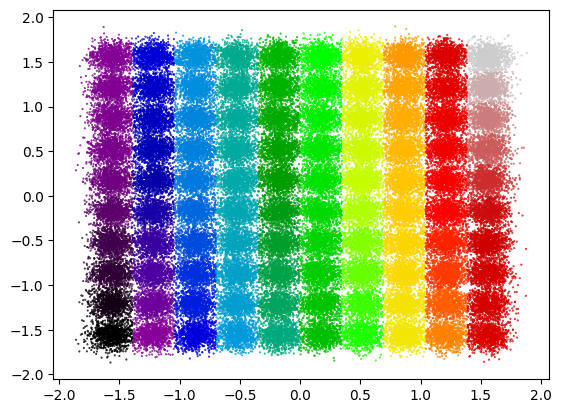

Dataset size: 100000 points


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/birch1.txt', sep=r"\s+", header=None).to_numpy()
data = (data - data.mean(0))/data.std(0)
labels = pd.read_csv('data/birch1_labels.txt', sep=r"\s+", header=None)
y_true = labels.to_numpy().flatten()
true_k = 100
plt.scatter(data[:, 0], data[:, 1], s=0.2, c=y_true, cmap='nipy_spectral')
plt.show()
print(f"Dataset size: {data.shape[0]} points")

Using branching factor B=64 and max_cfs 312
CFTree has 313 cfs: it is too big! Increasing threshold from 0.1 to 0.11410574662979311
CFTree has 313 cfs: it is too big! Increasing threshold from 0.11410574662979311 to 0.13599362291399528
279
ARI BIRCH: 0.9473367246655525


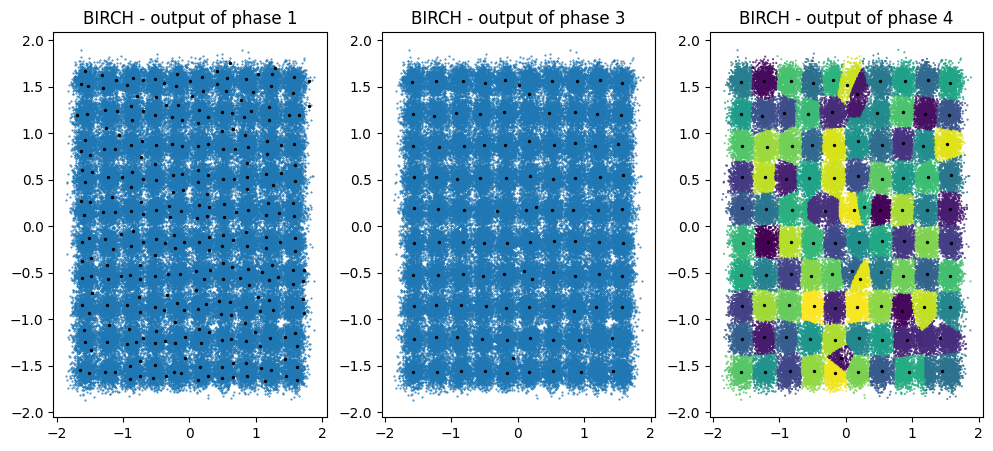

In [ ]:
#birch = Birch(threshold=0.01,branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=False)
memory_sizes = [10_000, 102_400, 500_000, 1_048_576]
birch = Birch(memory=10_000,page_size= 2048, cluster_method='kmeans', handle_outliers=False)
labels = birch.fit_predict(data, n_clusters=true_k)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.centroids[:, 0], birch.centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 1")
print(len(birch.centroids))
plt.subplot(1,3,2)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 3")
plt.subplot(1,3,3)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 4")
nmi_birch = normalized_mutual_info_score(y_true, labels)
print("ARI BIRCH:", nmi_birch)

Using branching factor B=128 and max_cfs 3200
CFTree has 3201 cfs: it is too big! Increasing threshold from 0 to 0.0011356294522729662
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.0011356294522729662 to 0.0021652995963680503
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.0021652995963680503 to 0.002823917169188728
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.002823917169188728 to 0.0032429676692037703
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.0032429676692037703 to 0.003796074035602948
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.003796074035602948 to 0.004836046185126332
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.004836046185126332 to 0.005057146912192169
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.005057146912192169 to 0.005400217416706851
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.005400217416706851 to 0.005914273012101219
CFTr

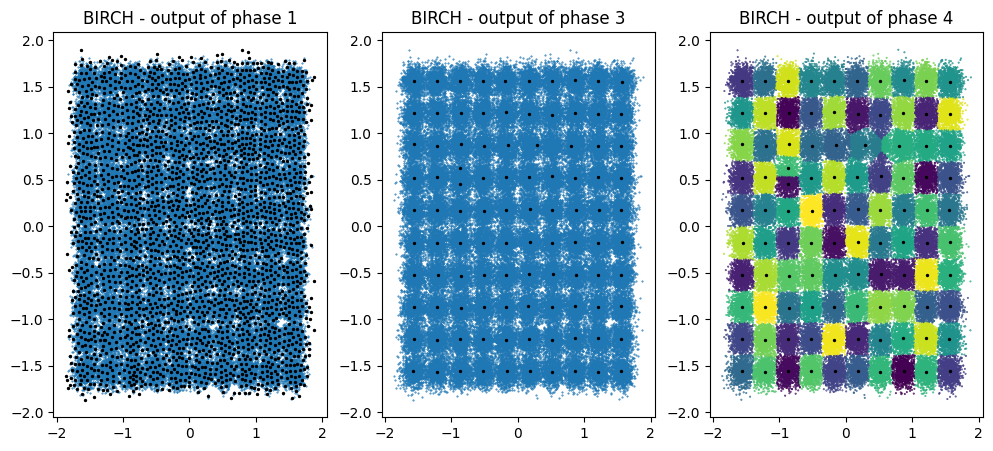

In [ ]:
# It took almost 3 minutes
# Best ari: 102_400 + 4096
birch = Birch(memory=102_400, threshold=0.0399325253719791, page_size=4096, cluster_method='kmeans', handle_outliers=False)
labels = birch.fit_predict(data, n_clusters=true_k)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.centroids[:, 0], birch.centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 1")
print(len(birch.centroids))
plt.subplot(1,3,2)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 3")
plt.subplot(1,3,3)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 4")
nmi_birch = normalized_mutual_info_score(y_true, labels)
print("ARI BIRCH:", nmi_birch)

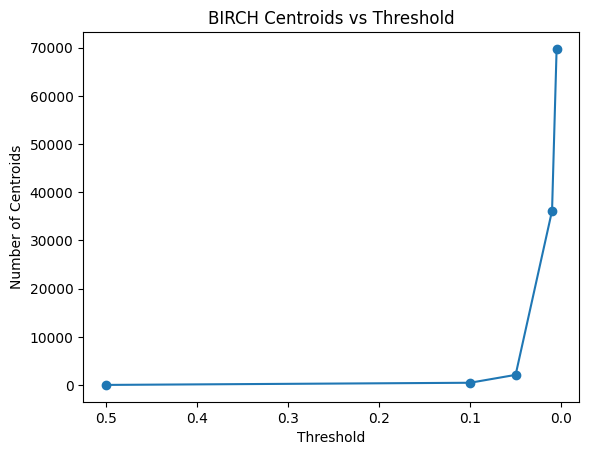

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define threshold range (lowering from 0.5)
thresholds = [0.5, 0.1, 0.05, 0.01, 0.005]

num_centroids = []

for t in thresholds:
    birch = Birch(
        threshold=t,
        branching_factor=50,
        leaf_size=50,
        cluster_method='agglomerative',
        handle_outliers=True
    )
    
    birch.fit_predict(data, n_clusters=true_k)
    num_centroids.append(len(birch.centroids))

# Plot
plt.figure()
plt.plot(thresholds, num_centroids, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Number of leaf CFs")
plt.title("BIRCH Leaf Entries vs Threshold")
plt.gca().invert_xaxis()  # so decreasing threshold goes left to right

# ---- ADD VALUE LABELS ----
for x, y in zip(thresholds, num_centroids):
    plt.annotate(
        str(y),
        (x, y),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        fontsize=9
    )
plt.show()


Using branching factor B=64 and max_cfs 312
CFTree has 313 cfs: it is too big! Increasing threshold from 0.01 to 0.010166339140653078
CFTree has 313 cfs: it is too big! Increasing threshold from 0.010166339140653078 to 0.01111859135888159
CFTree has 313 cfs: it is too big! Increasing threshold from 0.01111859135888159 to 0.01220208824912181
CFTree has 313 cfs: it is too big! Increasing threshold from 0.01220208824912181 to 0.013285515086135641
CFTree has 313 cfs: it is too big! Increasing threshold from 0.013285515086135641 to 0.014536964692112948
CFTree has 313 cfs: it is too big! Increasing threshold from 0.014536964692112948 to 0.015748406051693052
CFTree has 313 cfs: it is too big! Increasing threshold from 0.015748406051693052 to 0.01801238726182011
CFTree has 313 cfs: it is too big! Increasing threshold from 0.01801238726182011 to 0.020537655999268527
CFTree has 313 cfs: it is too big! Increasing threshold from 0.020537655999268527 to 0.02191407613604499
CFTree has 313 cfs: it is

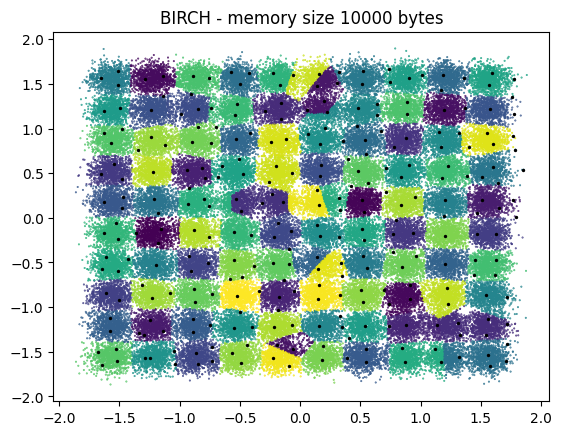

Using branching factor B=64 and max_cfs 3200
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.01 to 0.010707520022587153
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.010707520022587153 to 0.011960367278935919
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.011960367278935919 to 0.013484856342278003
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.013484856342278003 to 0.015050459012039842
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.015050459012039842 to 0.01715868890218588
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.01715868890218588 to 0.03245495574667876
CFTree has 3202 cfs: it is too big! Increasing threshold from 0.03245495574667876 to 0.040114824533677526
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.040114824533677526 to 0.049596209184891


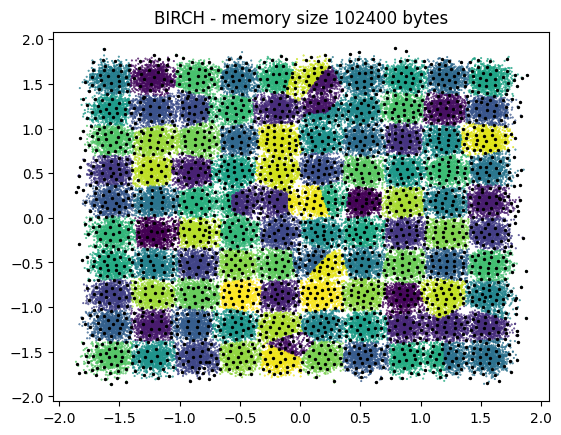

Using branching factor B=64 and max_cfs 15625
CFTree has 15626 cfs: it is too big! Increasing threshold from 0.01 to 0.010716643128391412
CFTree has 15626 cfs: it is too big! Increasing threshold from 0.010716643128391412 to 0.011846776852490536
CFTree has 15626 cfs: it is too big! Increasing threshold from 0.011846776852490536 to 0.013277380572559401
CFTree has 15626 cfs: it is too big! Increasing threshold from 0.013277380572559401 to 0.015146040268621212
CFTree has 15626 cfs: it is too big! Increasing threshold from 0.015146040268621212 to 0.01738758360969113
CFTree has 15626 cfs: it is too big! Increasing threshold from 0.01738758360969113 to 0.020388808498715518


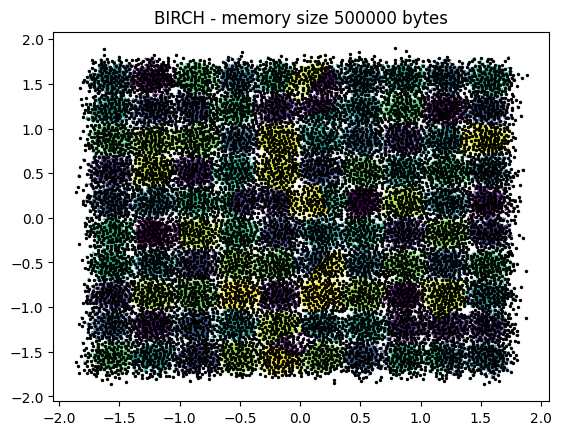

Using branching factor B=64 and max_cfs 32768
CFTree has 32769 cfs: it is too big! Increasing threshold from 0.01 to 0.010726170720677755
CFTree has 32769 cfs: it is too big! Increasing threshold from 0.010726170720677755 to 0.011924744560505574


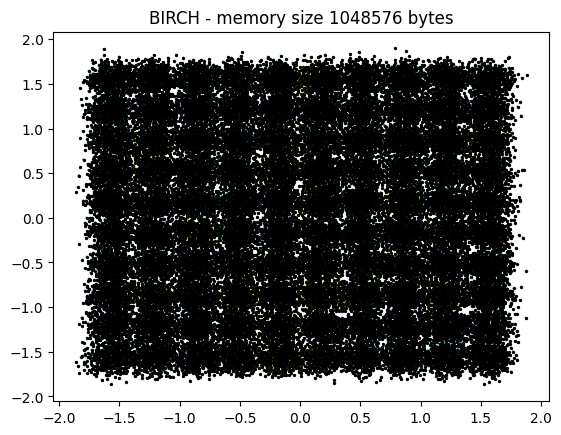

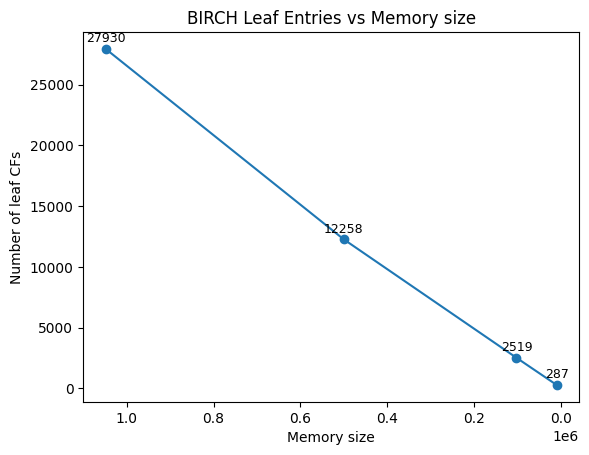

In [30]:
import numpy as np
import matplotlib.pyplot as plt

memory_sizes = [10_000, 102_400, 500_000, 1_048_576]

num_centroids = []

for mem in memory_sizes:
    birch = Birch(
        memory=mem,
        page_size= 2048,
        cluster_method='kmeans',
        handle_outliers=False,
        threshold=0.01
    )
    
    birch.fit_predict(data, n_clusters=true_k)
    num_centroids.append(len(birch.centroids))
    plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
    plt.scatter(birch.centroids[:, 0], birch.centroids[:, 1], c='black', s = 2)
    plt.title(f"BIRCH - memory size {mem} bytes")
    plt.show()

# Plot
plt.figure()
plt.plot(memory_sizes, num_centroids, marker='o')
plt.xlabel("Memory size")
plt.ylabel("Number of leaf CFs")
plt.title("BIRCH Leaf Entries vs Memory size")
plt.gca().invert_xaxis()  # so decreasing threshold goes left to right

# ---- ADD VALUE LABELS ----
for x, y in zip(memory_sizes, num_centroids):
    plt.annotate(
        str(y),
        (x, y),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        fontsize=9
    )
plt.show()

Using branching factor B=16 and max_cfs 3200
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.01 to 0.012672073667607206
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.012672073667607206 to 0.016061403866928378
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.016061403866928378 to 0.021574639402390797
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.021574639402390797 to 0.02824998422834271
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.02824998422834271 to 0.03735080548753961
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.03735080548753961 to 0.051228887447655365


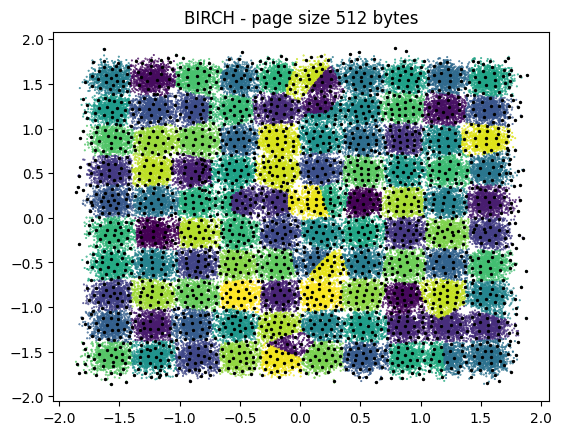

Using branching factor B=32 and max_cfs 3200
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.01 to 0.012006825083670427
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.012006825083670427 to 0.013875700078471576
CFTree has 3202 cfs: it is too big! Increasing threshold from 0.013875700078471576 to 0.016607936992550018
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.016607936992550018 to 0.02117513045188147
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.02117513045188147 to 0.02604754635672281
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.02604754635672281 to 0.031605088372542764
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.031605088372542764 to 0.039609802713728604
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.039609802713728604 to 0.050782988281582286


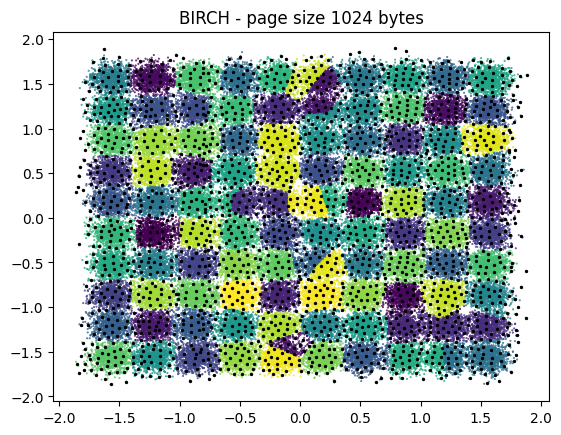

Using branching factor B=64 and max_cfs 3200
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.01 to 0.010707520022587153
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.010707520022587153 to 0.011960367278935919
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.011960367278935919 to 0.013484856342278003
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.013484856342278003 to 0.015050459012039842
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.015050459012039842 to 0.01715868890218588
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.01715868890218588 to 0.03245495574667876
CFTree has 3202 cfs: it is too big! Increasing threshold from 0.03245495574667876 to 0.040114824533677526
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.040114824533677526 to 0.049596209184891


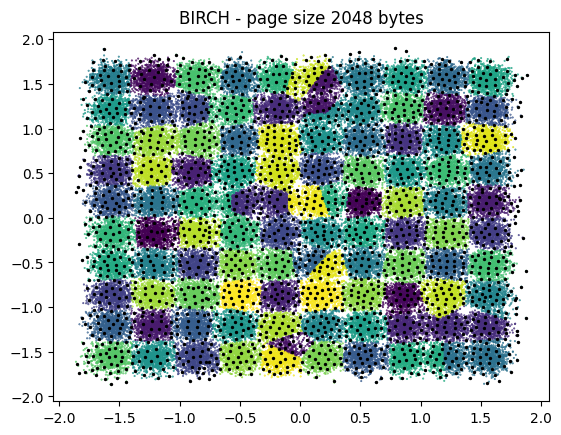

Using branching factor B=128 and max_cfs 3200
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.01 to 0.01005633428389312
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.01005633428389312 to 0.010811456908203928
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.010811456908203928 to 0.011590012127677999
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.011590012127677999 to 0.012144987762926154
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.012144987762926154 to 0.012814189071161974
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.012814189071161974 to 0.013924623044246057
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.013924623044246057 to 0.015109349266324519
CFTree has 3201 cfs: it is too big! Increasing threshold from 0.015109349266324519 to 0.016551409701759775
CFTree has 3202 cfs: it is too big! Increasing threshold from 0.016551409701759775 to 0.01822719673058097
CFTree has

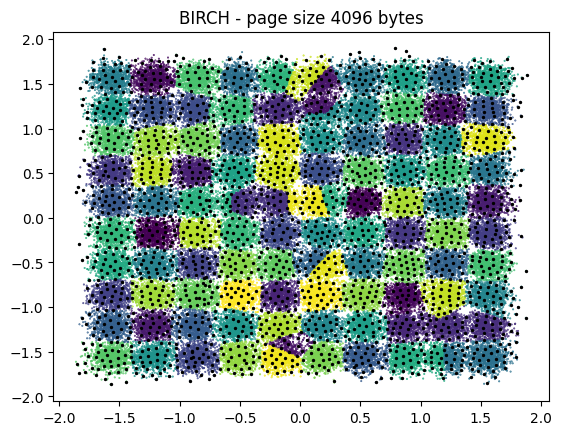

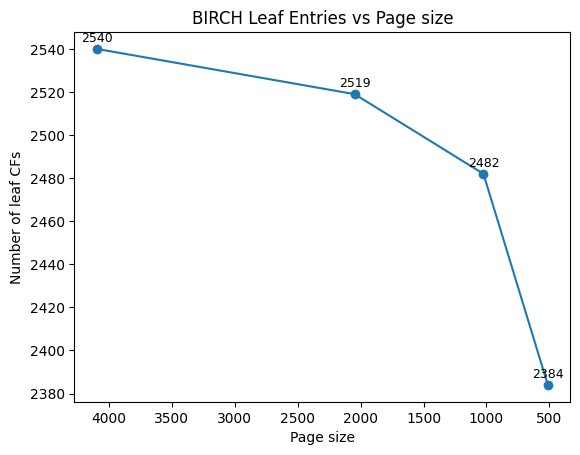

In [31]:
import numpy as np
import matplotlib.pyplot as plt

page_sizes = [512, 1024, 2048, 4096]

num_centroids = []

for page_size in page_sizes:
    birch = Birch(
        memory=102_400,
        page_size= page_size,
        cluster_method='kmeans',
        handle_outliers=False,
        threshold=0.01
    )
    
    birch.fit_predict(data, n_clusters=true_k)
    num_centroids.append(len(birch.centroids))
    plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
    plt.scatter(birch.centroids[:, 0], birch.centroids[:, 1], c='black', s = 2)
    plt.title(f"BIRCH - page size {page_size} bytes")
    plt.show()

# Plot
plt.figure()
plt.plot(page_sizes, num_centroids, marker='o')
plt.xlabel("Page size")
plt.ylabel("Number of leaf CFs")
plt.title("BIRCH Leaf Entries vs Page size")
plt.gca().invert_xaxis()  # so decreasing threshold goes left to right

# ---- ADD VALUE LABELS ----
for x, y in zip(page_sizes, num_centroids):
    plt.annotate(
        str(y),
        (x, y),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        fontsize=9
    )
plt.show()


In [122]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
kmeans = KMeans(true_k, init='k-means++')
kmeans_labels = kmeans.fit_predict(data)
dbscan = DBSCAN(eps=0.05, min_samples=100)
dbscan_labels = dbscan.fit_predict(data)
mini_kmeans = MiniBatchKMeans(n_clusters=true_k)
mini_kmeans_labels = mini_kmeans.fit_predict(data)

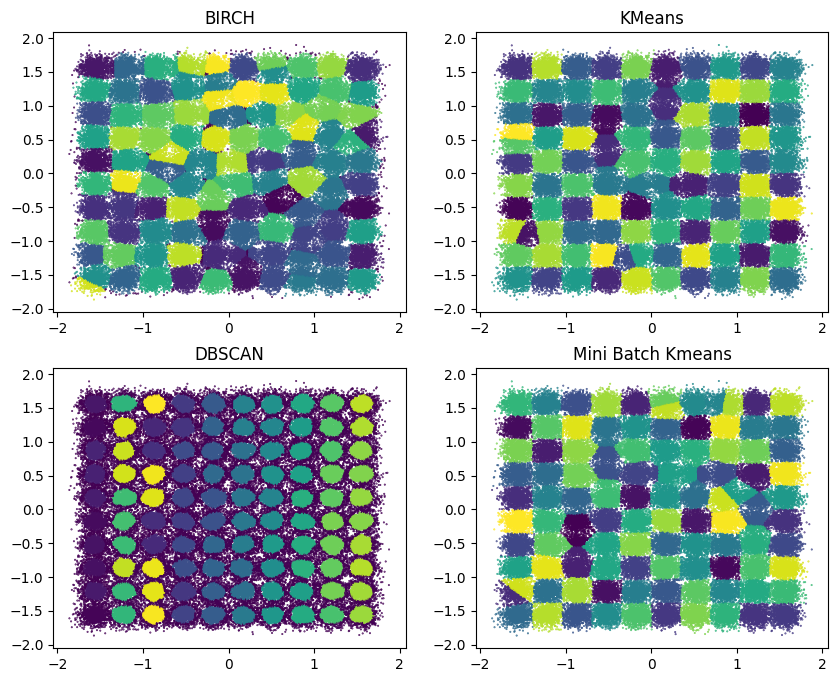

In [123]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
plt.title("BIRCH")
plt.subplot(2,2,2)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, s =0.2)
plt.title("KMeans")
plt.subplot(2,2,3)
plt.scatter(data[:, 0], data[:, 1], c=dbscan_labels, s =0.2)
plt.title("DBSCAN")
plt.subplot(2,2,4)
plt.scatter(data[:, 0], data[:, 1], c=mini_kmeans_labels, s =0.2)
plt.title("Mini Batch Kmeans")
plt.show()

In [141]:
def compare_clustering_methods(data, true_k):
    birch = Birch(threshold=0.1, branching_factor=50, leaf_size=50, cluster_method='kmeans')
    labels = birch.fit_predict(data, n_clusters=true_k)
    kmeans = KMeans(true_k, init='k-means++')
    kmeans_labels = kmeans.fit_predict(data)
    dbscan = DBSCAN()
    dbscan_labels = dbscan.fit_predict(data)
    mini_kmeans = MiniBatchKMeans(n_clusters=true_k)
    mini_kmeans_labels = mini_kmeans.fit_predict(data)
    return labels, kmeans_labels, dbscan_labels, mini_kmeans_labels

## Noisy blobs experiments

Dataset size: 105000 points


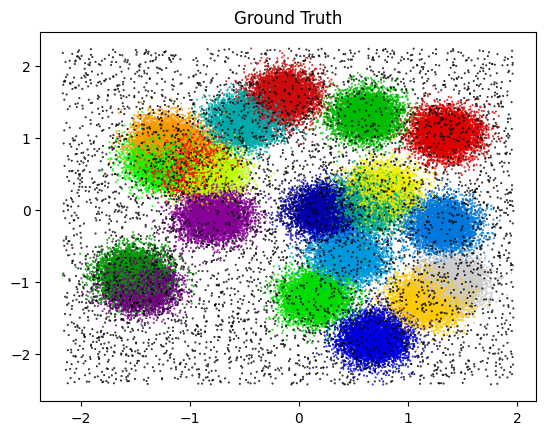

In [ ]:
from sklearn.datasets import make_blobs
true_k = 20
data, y_true = make_blobs(n_samples=100_000, centers=true_k, random_state=170)
mins, maxs = data.min(axis=0), data.max(axis=0)
noise = np.random.uniform(mins, maxs, size=(5000, 2))
data = np.vstack([data, noise])
data = (data - data.mean(0))/data.std(0)
y_true = np.hstack([y_true, [-1]*5000])  # label noise as -1
size = 0.2
print(f"Dataset size: {data.shape[0]} points")
plt.scatter(data[:, 0], data[:, 1], s=size, c=y_true, cmap='nipy_spectral')
plt.title('Ground Truth')
plt.show()

0.2 -> around 300 points (value obtained with previous iterations)

0.05 -> 4.426 points

Number of leaf entries: 4426


Text(0.5, 1.0, 'BIRCH - final clustering')

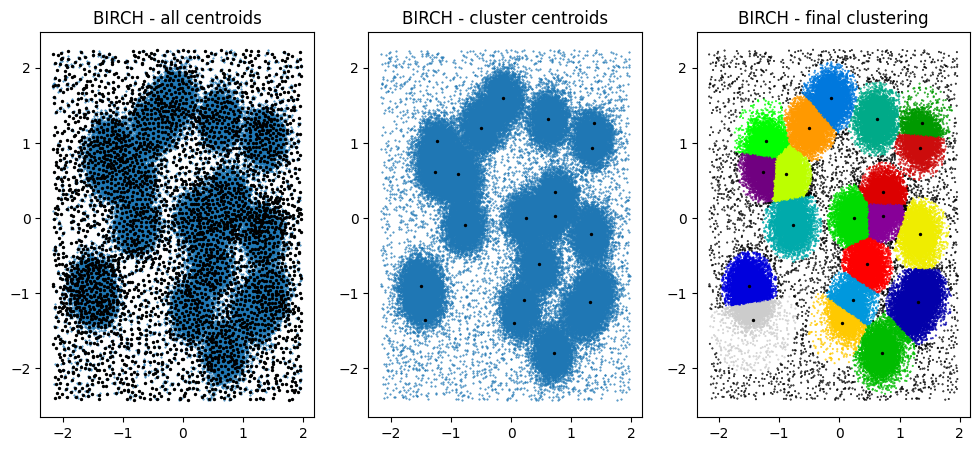

In [146]:
birch = Birch(branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=True, threshold=0.05)
labels = birch.fit_predict(data, n_clusters=true_k)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.centroids[:, 0], birch.centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - all centroids")
print(f"Number of leaf entries: {len(birch.centroids)}")
plt.subplot(1,3,2)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
birch.cluster_centroids
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - cluster centroids")
plt.subplot(1,3,3)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2, cmap='nipy_spectral')
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - final clustering")

## Big blobs experiments

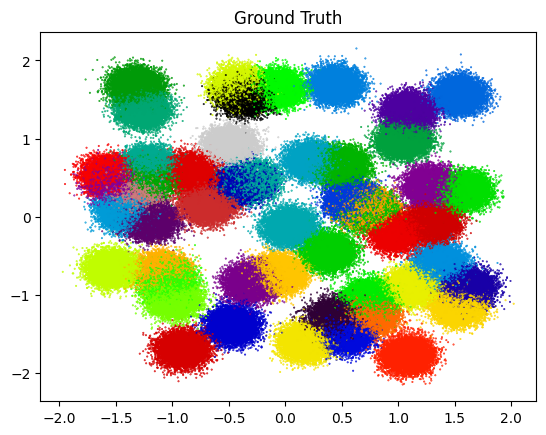

In [128]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

N_SAMPLES = 500_000   # increase to 1–2 million if your machine allows
N_FEATURES = 20
N_CLUSTERS = 50

X, y_true = make_blobs(
    n_samples=N_SAMPLES,
    n_features=N_FEATURES,
    centers=N_CLUSTERS,
    cluster_std=0.6,
    random_state=42
)

X = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], c=y_true, s=0.2, cmap='nipy_spectral')
plt.title('Ground Truth')
plt.show()


87757


Text(0.5, 1.0, 'BIRCH - output of phase 4')

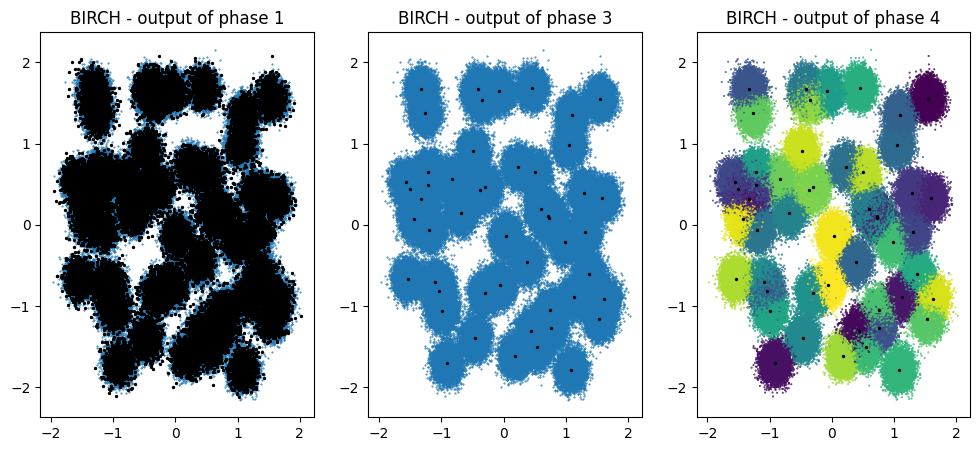

In [ ]:
birch = Birch(threshold=0.5,branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=False)
data=X
true_k=N_CLUSTERS
labels = birch.fit_predict(data, n_clusters=true_k)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.centroids[:, 0], birch.centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 1")
print(f"Number of leaf entries: {len(birch.centroids)}")
plt.subplot(1,3,2)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 3")
plt.subplot(1,3,3)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 4")

Number of leaf entries: 4966


Text(0.5, 1.0, 'BIRCH - output of phase 4')

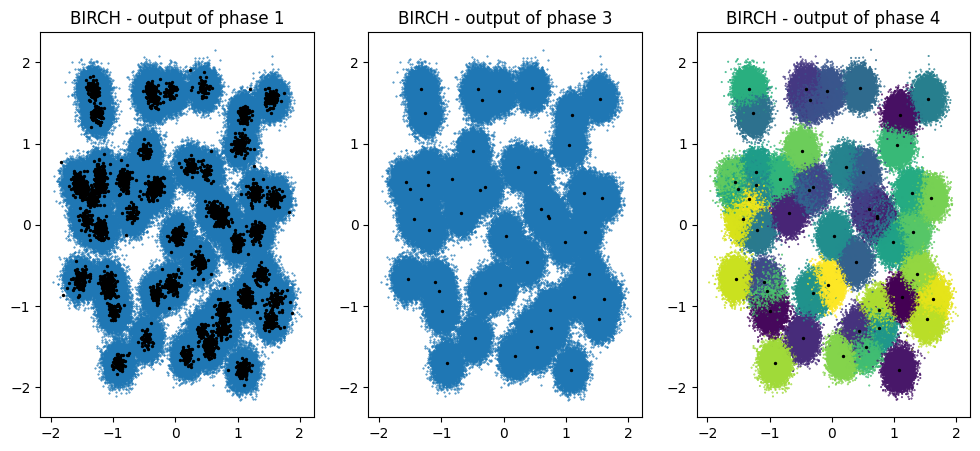

In [132]:
birch = Birch(threshold=0.6,branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=False)
data=X
true_k=N_CLUSTERS
labels = birch.fit_predict(data, n_clusters=true_k)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.centroids[:, 0], birch.centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 1")
print(f"Number of leaf entries: {len(birch.centroids)}")
plt.subplot(1,3,2)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 3")
plt.subplot(1,3,3)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 4")

68


Text(0.5, 1.0, 'BIRCH - output of phase 4')

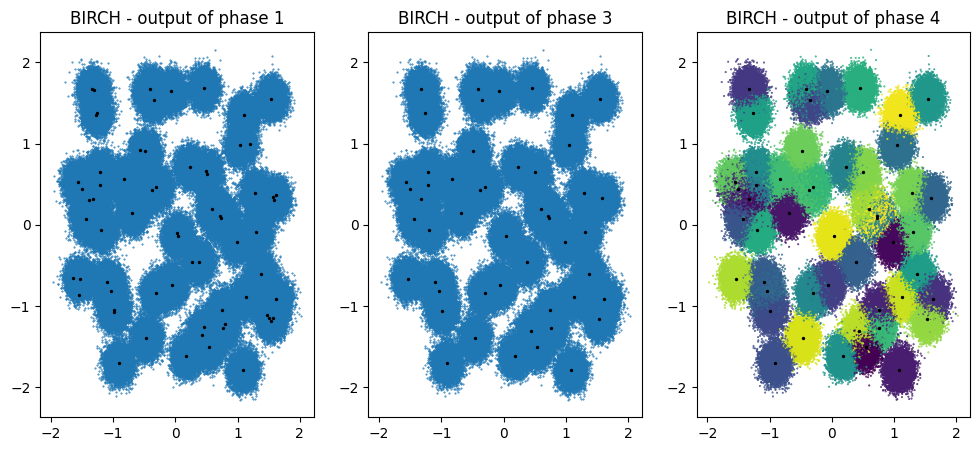

In [131]:
birch = Birch(threshold=0.8,branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=False)
data=X
true_k=N_CLUSTERS
labels = birch.fit_predict(data, n_clusters=true_k)
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.centroids[:, 0], birch.centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 1")
print(f"Number of leaf entries: {len(birch.centroids)}")
plt.subplot(1,3,2)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 3")
plt.subplot(1,3,3)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - output of phase 4")

In [ ]:
from sklearn.cluster import KMeans
import time

start = time.time()
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    n_init=10,
    random_state=42
)
kmeans.fit(X)
print("KMeans time:", time.time() - start)


start = time.time()
birch_final = Birch(
    threshold=0.8,
    branching_factor=50
)
labels = birch_final.fit_predict(X, n_clusters=N_CLUSTERS)
print("Total BIRCH time:", time.time() - start)


from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(y_true, kmeans.labels_)
ari_birch = adjusted_rand_score(y_true, labels)

print("ARI KMeans:", ari_kmeans)
print("ARI BIRCH:", ari_birch)


KMeans time: 25.874433040618896
Total BIRCH time: 181.1764144897461
ARI KMeans: 1.0
ARI BIRCH: 1.0


## Sine Experiments

Dataset size: 100000 points


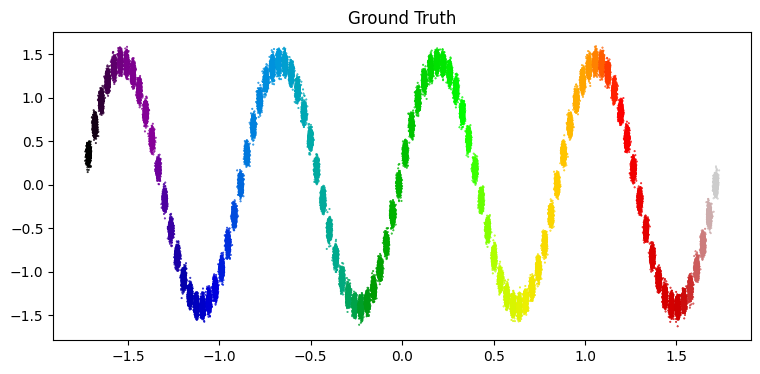

In [150]:
data = pd.read_csv('data/birch2.txt', sep=r"\s+", header=None).to_numpy()
data = (data - data.mean(0))/data.std(0)
labels = pd.read_csv('data/birch2_labels.txt', sep=r"\s+", header=None)
y_true = labels.to_numpy().flatten()
true_k = 100
size = 0.2
plt.figure(figsize=(9,4))
print(f"Dataset size: {data.shape[0]} points")
plt.scatter(data[:, 0], data[:, 1], s=size, c=y_true, cmap='nipy_spectral')
plt.title('Ground Truth')
plt.show()

0.5 -> 18 points

0.1 -> 135 points (NMI = 0.91)

0.01 -> 3599 (NMI = 0.917) (0.886 with agglomerative)

0.005 -> 11856 (NMI = 0.917)

Number of leaf entries: 3599
ARI BIRCH: 0.886139780325499


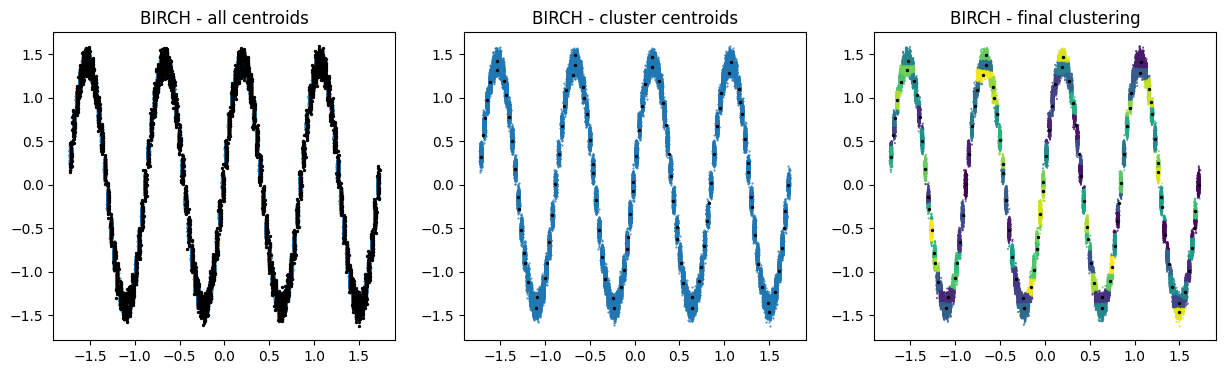

In [ ]:
birch = Birch(branching_factor=50, leaf_size=50, cluster_method='kmeans', handle_outliers=False, threshold=0.01)
labels = birch.fit_predict(data, n_clusters=true_k)
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
plt.scatter(birch.centroids[:, 0], birch.centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - all centroids")
print(f"Number of leaf entries: {len(birch.centroids)}")
plt.subplot(1,3,2)
plt.scatter(data[:, 0], data[:, 1], s = 0.2)
birch.cluster_centroids
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - cluster centroids")
plt.subplot(1,3,3)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
plt.scatter(birch.cluster_centroids[:, 0], birch.cluster_centroids[:, 1], c='black', s = 2)
plt.title("BIRCH - final clustering")
nmi_birch = normalized_mutual_info_score(y_true, labels)
print("ARI BIRCH:", nmi_birch)
